In [1]:
import pandas as pd
import numpy as np
import os
from astropy.cosmology import Planck13
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

import disperse

from sklearn.neighbors import KDTree

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgbm

In [2]:
cosmo = Planck13
H0 = cosmo.H0.value
Om = cosmo.Om0
Ol = 0.69288
Ok = 0.0
print(f'H0 = {cosmo.H0.value}')
print(f'Om = {cosmo.Om0}')
print(f'Ol = {0.69288}')

H0 = 67.77
Om = 0.30712
Ol = 0.69288


In [3]:
gal_RA_int = (140, 260)
gal_DEC_int = (-10, 30)
gal_Z_int = (0, 1.0)

In [4]:
galaxies = pd.read_csv('SDSS/SDSS_DR16.csv')
galaxies = galaxies[galaxies['class'] == 'GALAXY']
galaxies = galaxies[(gal_RA_int[0] <= galaxies['ra']) & (galaxies['ra'] <= gal_RA_int[1])]
galaxies = galaxies[(gal_DEC_int[0] <= galaxies['dec']) & (galaxies['dec'] <= gal_DEC_int[1])]
galaxies = galaxies[(gal_Z_int[0] < galaxies['z']) & (galaxies['z'] <= gal_Z_int[1])]
galaxies = galaxies[['ra', 'dec', 'z']]
galaxies.columns = ['RA', 'DEC', 'Z']
galaxies.drop_duplicates(subset=['RA', 'DEC', 'Z'])
galaxies.reset_index(drop=True, inplace=True)

In [5]:
cl_RA_int = (160, 240)
cl_DEC_int = (0, 20)
cl_Z_int = (0, 1.0)

In [6]:
dat = Table.read('DR5_cluster-catalog_v1.1.fits', format='fits')

clusters = dat[['RADeg', 'decDeg', 'redshift', 'redshiftType', 'M500c']].to_pandas()
clusters = clusters[clusters['redshiftType'] == b'spec']
clusters = clusters[['RADeg', 'decDeg', 'redshift', 'M500c']]
clusters.columns = ['RA', 'DEC', 'Z', 'M']
clusters = clusters[(cl_RA_int[0] <= clusters['RA']) & (clusters['RA'] <= cl_RA_int[1])]
clusters = clusters[(cl_DEC_int[0] <= clusters['DEC']) & (clusters['DEC'] <= cl_DEC_int[1])]
clusters = clusters[(cl_Z_int[0] < clusters['Z']) & (clusters['Z'] <= cl_Z_int[1])]
clusters = clusters[['RA', 'DEC', 'Z', 'M']]
clusters.columns = ['RA', 'DEC', 'Z', 'M']
clusters.drop_duplicates(subset=['RA', 'DEC', 'Z', 'M'])
clusters = clusters.sort_values(by=['Z'])
clusters.reset_index(drop=True, inplace=True)
clusters = clusters.assign(R=[0] * clusters.shape[0])
clusters

,RA,DEC,Z,M,R
0,230.761495,8.587807,0.035200,1.676978,0
1,230.452957,7.709549,0.044200,2.457475,0
2,227.733561,5.744353,0.076600,11.002140,0
3,208.253128,5.139146,0.078800,1.222567,0
4,173.207731,14.465334,0.083200,2.935207,0
...,...,...,...,...,...
514,190.801637,13.213381,0.789772,1.827705,0
515,160.265704,10.675110,0.789868,4.328044,0
516,199.909131,15.890405,0.796336,1.899555,0
517,211.772844,10.806421,0.836000,6.430338,0


In [7]:
test_mask = np.array([False] * clusters.shape[0])
test_mask[list(range(0, clusters.shape[0], 20))] = True
train_clusters = clusters.loc[~test_mask].reset_index(drop=True)
train_clusters['type'] = [1] * train_clusters.shape[0]
test_clusters = clusters.loc[test_mask].reset_index(drop=True)

In [8]:
train_clusters

,RA,DEC,Z,M,R,type
0,230.452957,7.709549,0.044200,2.457475,0,1
1,227.733561,5.744353,0.076600,11.002140,0,1
2,208.253128,5.139146,0.078800,1.222567,0,1
3,173.207731,14.465334,0.083200,2.935207,0,1
4,163.466549,16.844133,0.085400,2.420530,0,1
...,...,...,...,...,...,...
488,190.801637,13.213381,0.789772,1.827705,0,1
489,160.265704,10.675110,0.789868,4.328044,0,1
490,199.909131,15.890405,0.796336,1.899555,0,1
491,211.772844,10.806421,0.836000,6.430338,0,1


In [9]:
test_clusters

,RA,DEC,Z,M,R
0,230.761495,8.587807,0.035200,1.676978,0
1,217.958949,13.531505,0.159770,1.672366,0
2,221.662409,17.849673,0.200000,2.159093,0
3,194.112418,4.674226,0.230702,3.048494,0
4,201.756210,2.203833,0.260000,4.595230,0
5,233.943396,0.066695,0.295000,2.186019,0
6,217.243121,1.744618,0.317215,3.075904,0
7,225.037556,6.820814,0.334927,1.533393,0
8,185.157410,13.602676,0.349000,1.822679,0
9,235.816492,7.961940,0.360000,3.941155,0


In [10]:
util_DPS = disperse.Disperse3D(
    galaxies, '_disperse_03/bin/',
    H0, Om, Ol, Ok,
    clusters=clusters
)

In [11]:
#генерация случайных скоплений
RANDOM_CL_NUM = 3000
TRUE_R = 20
TRUE_CL_NUM = train_clusters.shape[0]

RA_int = (clusters['RA'].min(), clusters['RA'].max())
DEC_int = (clusters['DEC'].min(), clusters['DEC'].max())
Z_int = (clusters['Z'].min(), np.quantile(clusters['Z'], [1])[0])

np.random.seed(0)
CX, CY, CZ = util_DPS.sph2cart(
    train_clusters['RA'], train_clusters['DEC'], train_clusters['Z']
)
points = [[CX[i], CY[i], CZ[i]] for i in range(train_clusters.shape[0])]
kd_tree = KDTree(points, leaf_size=2)

not_generate = RANDOM_CL_NUM
RA, DEC, Z = np.array([]), np.array([]), np.array([])
while not_generate > 0:
    print('###')
    RA_ = np.random.uniform(RA_int[0], RA_int[1], not_generate)
    DEC_ = np.random.uniform(DEC_int[0], DEC_int[1], not_generate)
    Z_ = np.random.uniform(Z_int[0], Z_int[1], not_generate)
    CX, CY, CZ = util_DPS.sph2cart(RA_, DEC_, Z_)
    points = [[CX[i], CY[i], CZ[i]] for i in range(not_generate)]
    inters = kd_tree.query_radius(points, TRUE_R, count_only=True)
    RA = np.concatenate((RA, RA_[inters==0]))
    DEC = np.concatenate((DEC, DEC_[inters==0]))
    Z = np.concatenate((Z, Z_[inters==0]))
    not_generate = RANDOM_CL_NUM - len(RA)
    
M = [0] * RANDOM_CL_NUM
R = [0] * RANDOM_CL_NUM
type_ = [0] * RANDOM_CL_NUM

false_clusters = pd.DataFrame({
    'RA': RA, 'DEC': DEC, 'Z': Z, 'M': M, 'R': R, 'type': type_
})
false_clusters

###
###


,RA,DEC,Z,M,R,type
0,203.937346,8.307028,0.387431,0,0,0
1,217.176647,12.599870,0.438079,0,0,0
2,208.230389,15.565185,0.677137,0,0,0
3,203.624592,17.017795,0.599971,0,0,0
4,193.977886,16.318197,0.101440,0,0,0
...,...,...,...,...,...,...
2995,210.330586,10.944298,0.200164,0,0,0
2996,179.026674,17.523120,0.769965,0,0,0
2997,201.290266,6.313149,0.717217,0,0,0
2998,199.060248,14.029209,0.136485,0,0,0


In [12]:
train_clusters = pd.concat((train_clusters, false_clusters), axis=0)
train_clusters.reset_index(drop=True, inplace=True)
CX, CY, CZ = util_DPS.sph2cart(
    train_clusters['RA'],
    train_clusters['DEC'],
    train_clusters['Z']
)
train_clusters['CX'] = CX
train_clusters['CY'] = CY
train_clusters['CZ'] = CZ
train_clusters

,RA,DEC,Z,M,R,type,CX,CY,CZ
0,230.452957,7.709549,0.044200,2.457475,0,1,-122.101803,-147.873793,25.960786
1,227.733561,5.744353,0.076600,11.002140,0,1,-222.703294,-245.035914,33.308899
2,208.253128,5.139146,0.078800,1.222567,0,1,-300.190348,-161.319215,30.649445
3,173.207731,14.465334,0.083200,2.935207,0,1,-346.994931,41.329156,90.147741
4,163.466549,16.844133,0.085400,2.420530,0,1,-339.698430,100.839024,107.282298
...,...,...,...,...,...,...,...,...,...
3488,210.330586,10.944298,0.200164,0.000000,0,0,-714.693464,-418.145092,160.117286
3489,179.026674,17.523120,0.769965,0.000000,0,0,-2654.437060,45.097240,838.239508
3490,201.290266,6.313149,0.717217,0.000000,0,0,-2436.423124,-949.444865,289.292988
3491,199.060248,14.029209,0.136485,0.000000,0,0,-535.830778,-185.131799,141.653872


In [13]:
sigmas = [round(i, 1) for i in np.arange(0.2, 14.2, 0.2)]

In [14]:
f_name = 'ACT_03_dists.npy'
if os.path.exists(f_name):
    with open(f_name, 'rb') as f:
        dists = np.load(f)
else:
    dists = []
    for sigma in tqdm(sigmas):
        DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')

        _, _, cl_dists \
            = DPS.count_conn(train_clusters['R'], train_clusters)
        dists.append(np.array(cl_dists)[None,:])
    dists = np.concatenate(dists, axis=0)
    dists = dists.T
    with open(f_name, 'wb') as f:
        np.save(f, dists)
    
dists.shape

(3493, 70)

In [15]:
rads = list(range(1, 31))

In [16]:
sigma_scores = []
for i, rad in tqdm(enumerate(rads)):
    s = np.zeros(train_clusters.shape[0])
    for j, sigma in enumerate(sigmas):
        s[dists[:,j] <= rad] = sigma
    sigma_scores.append(s)
    
sigma_scores = np.array(sigma_scores).T
sigma_scores.shape

30it [00:00, 2070.78it/s]


(3493, 30)

<ipython-input-17-7c7d37dafa09>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(18, 12))


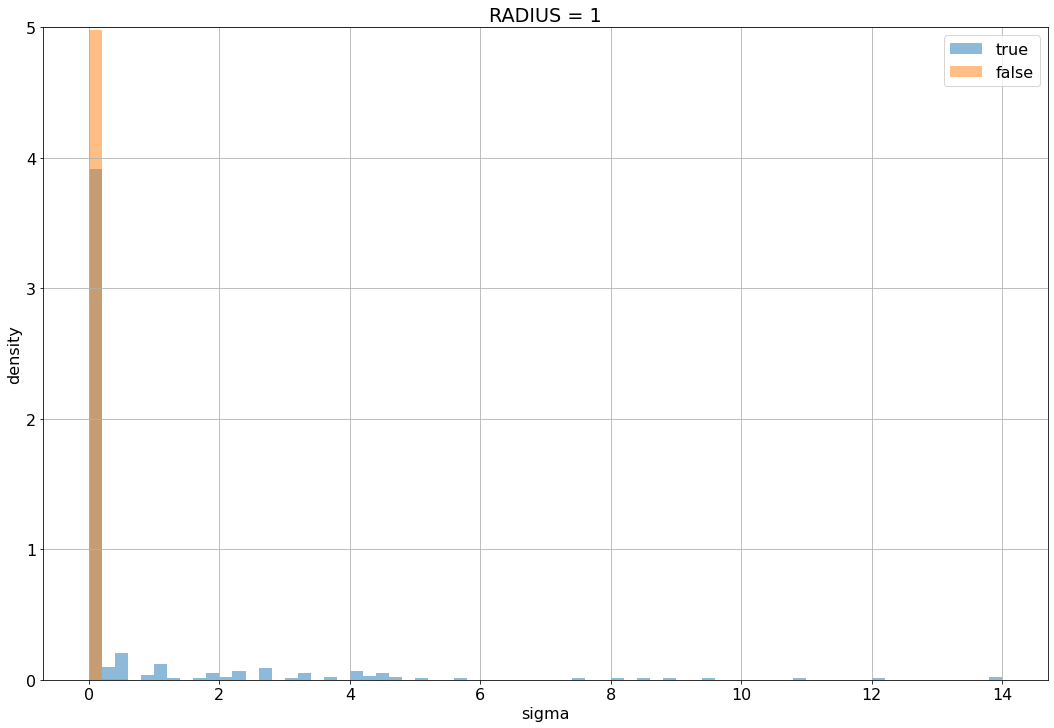

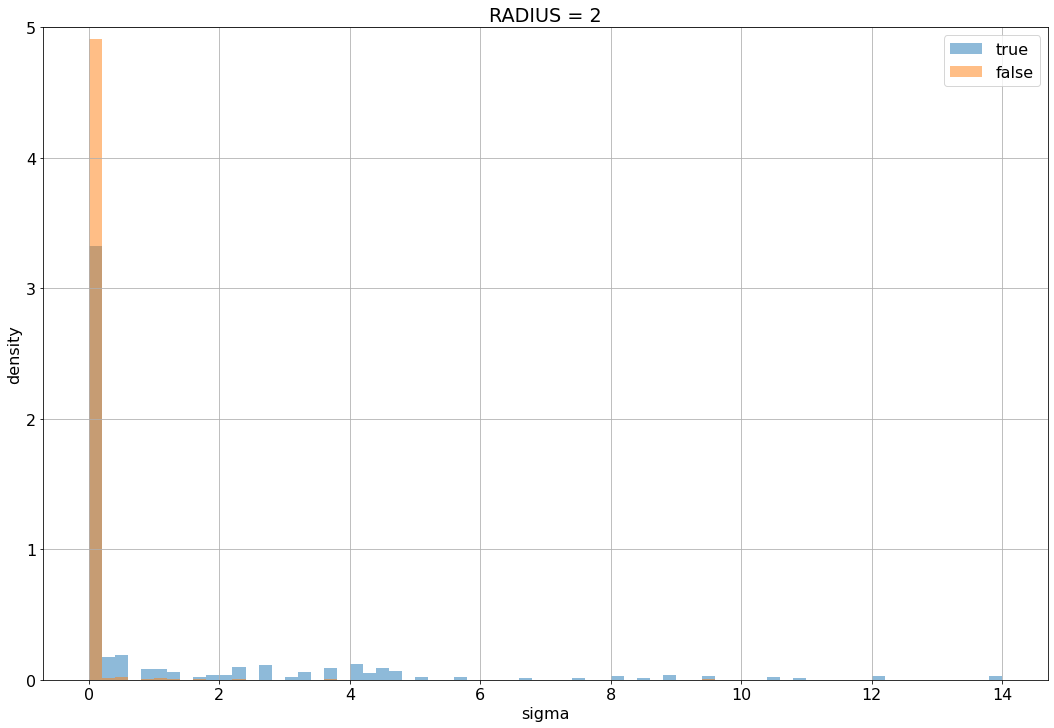

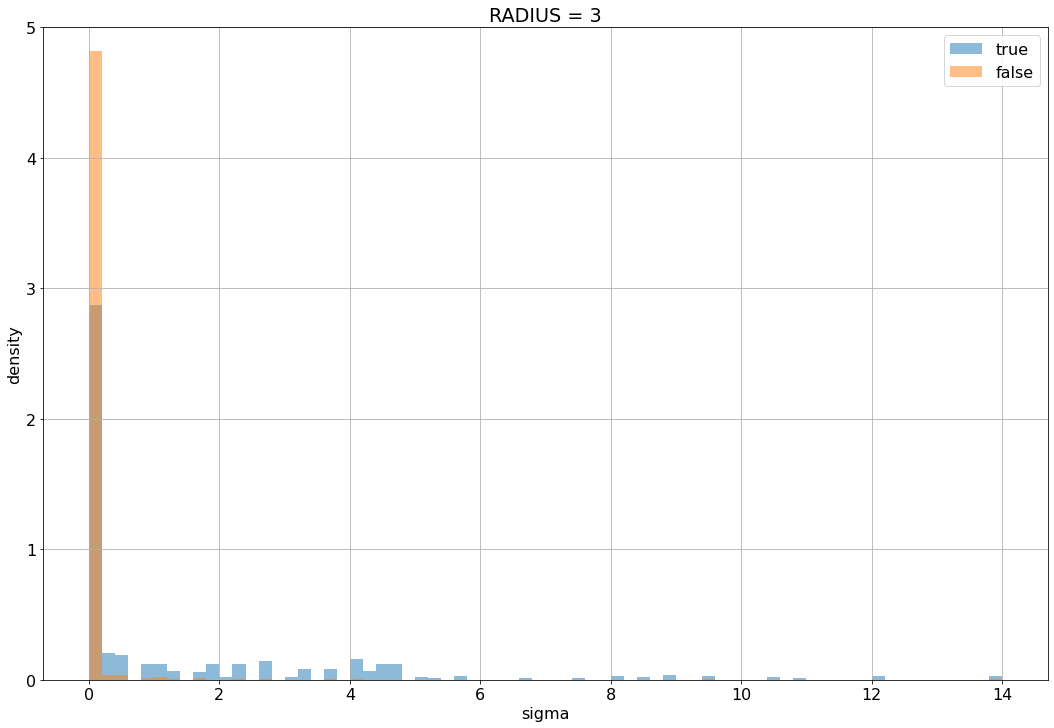

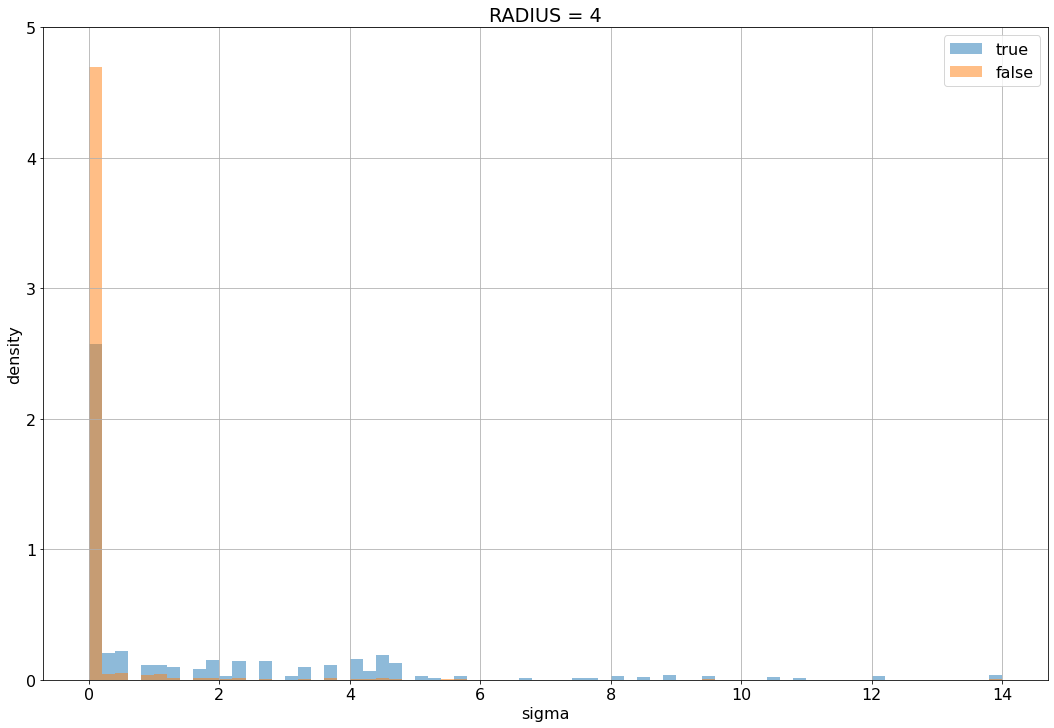

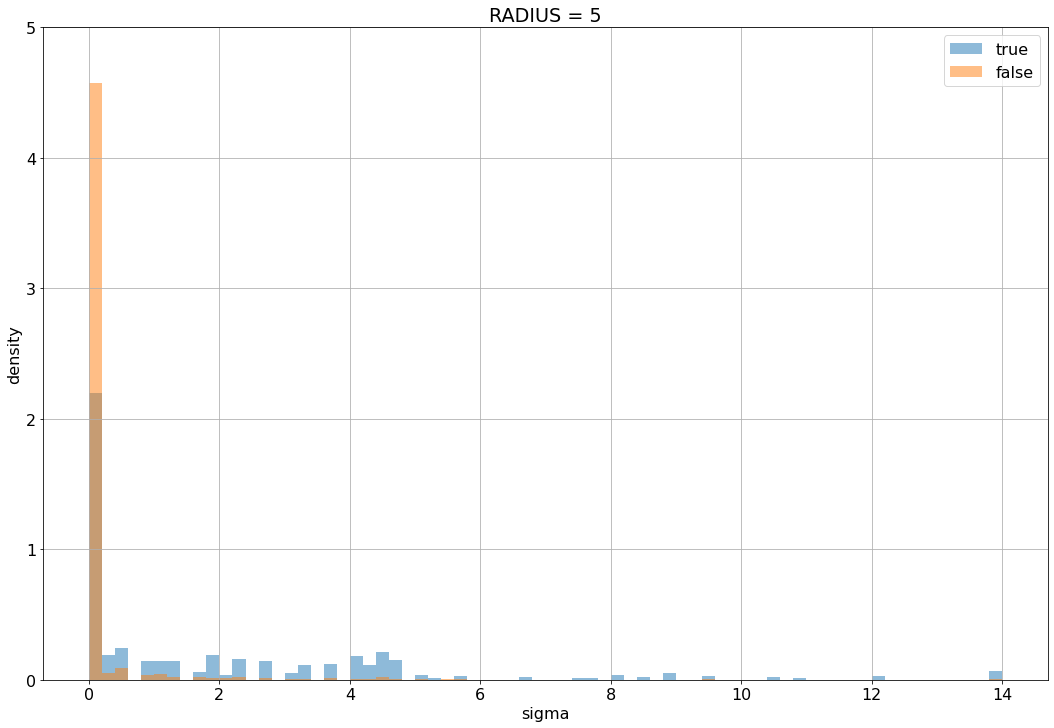

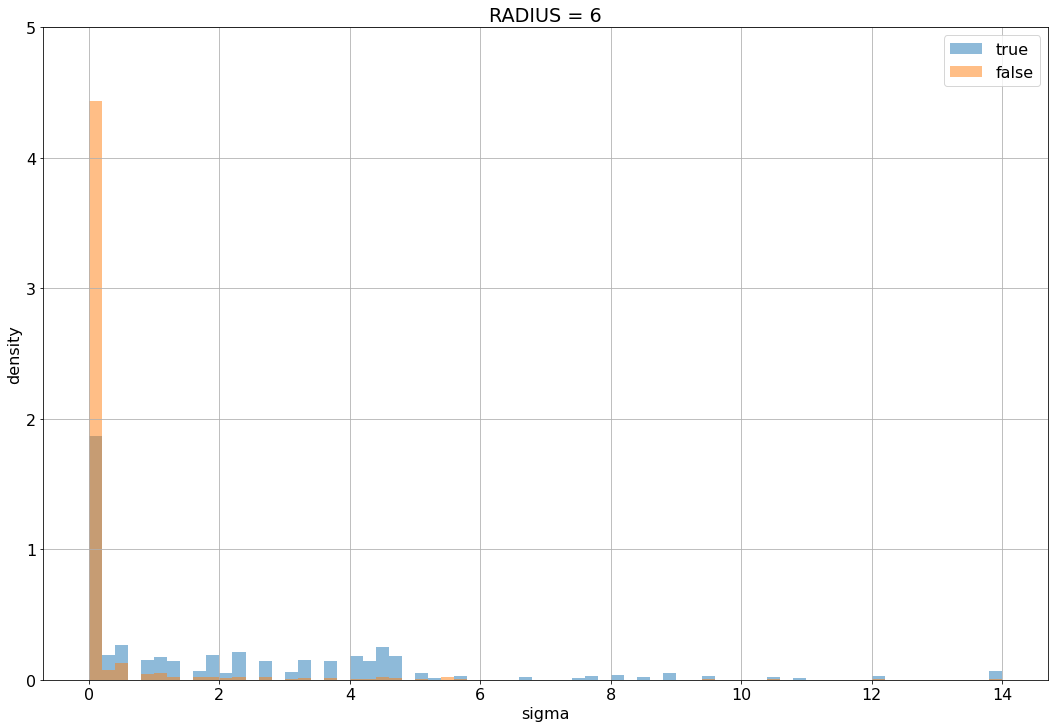

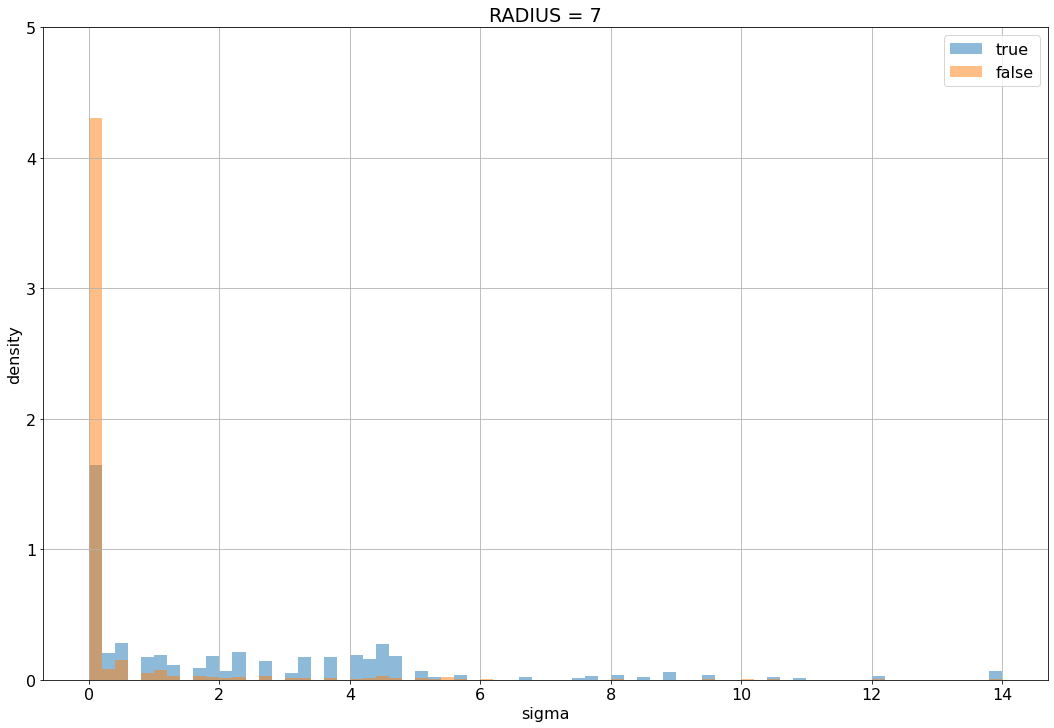

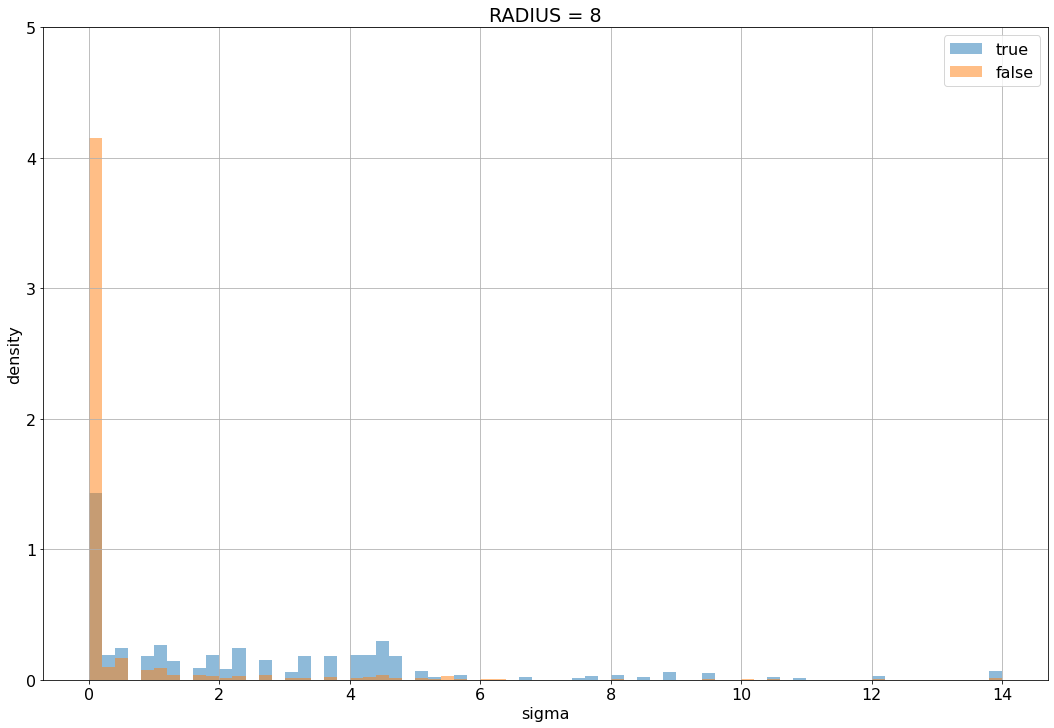

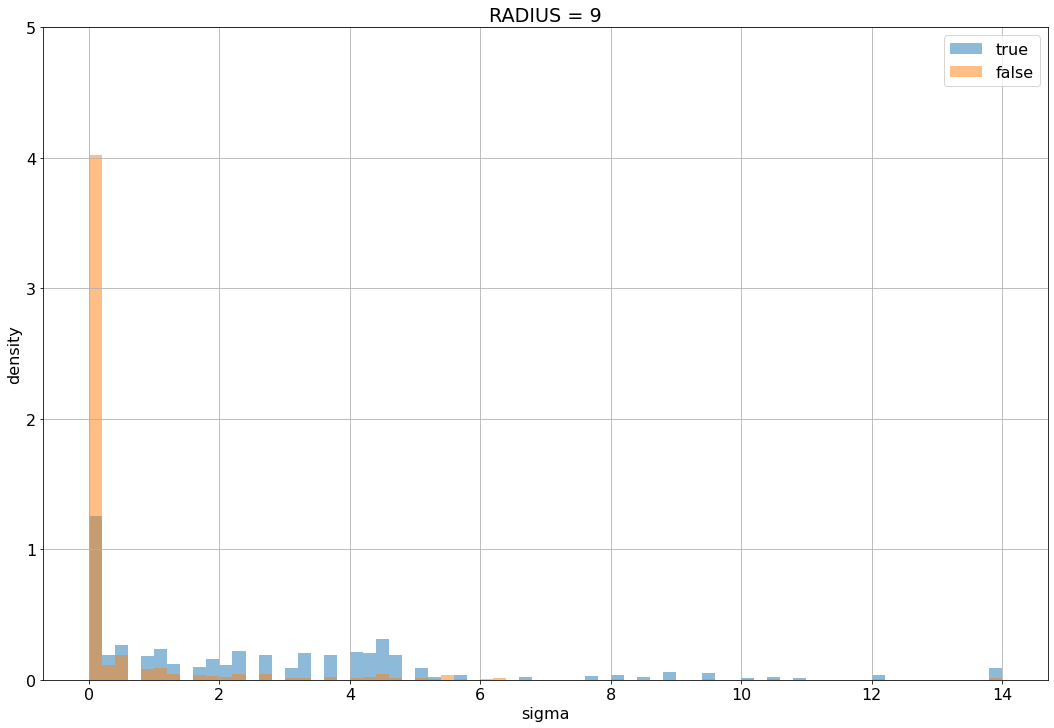

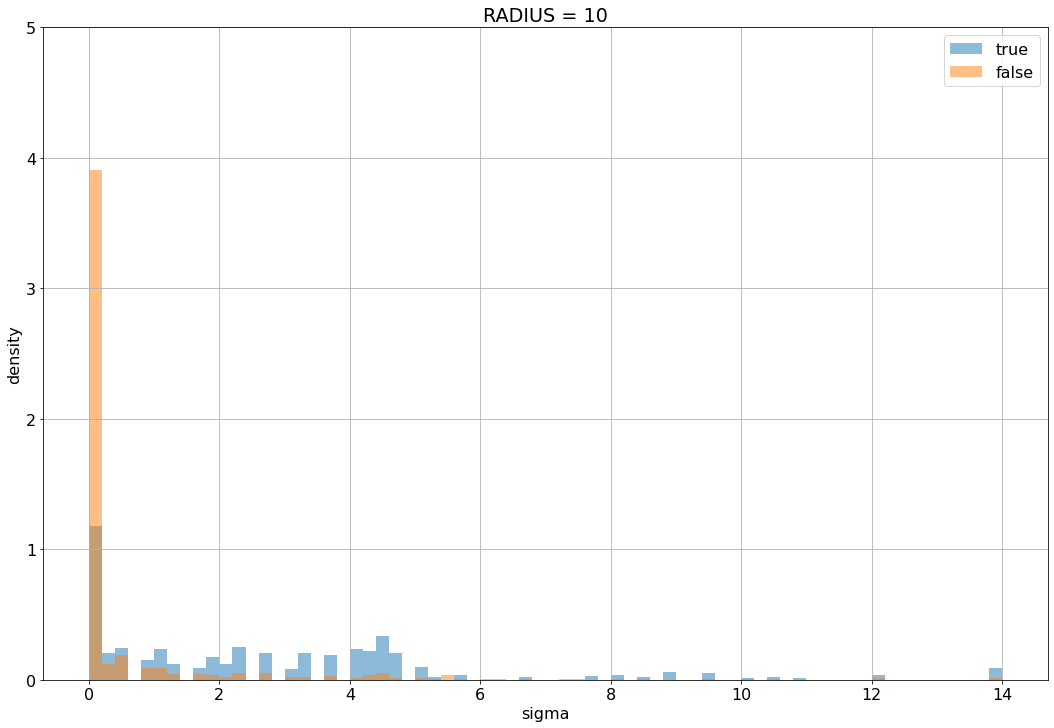

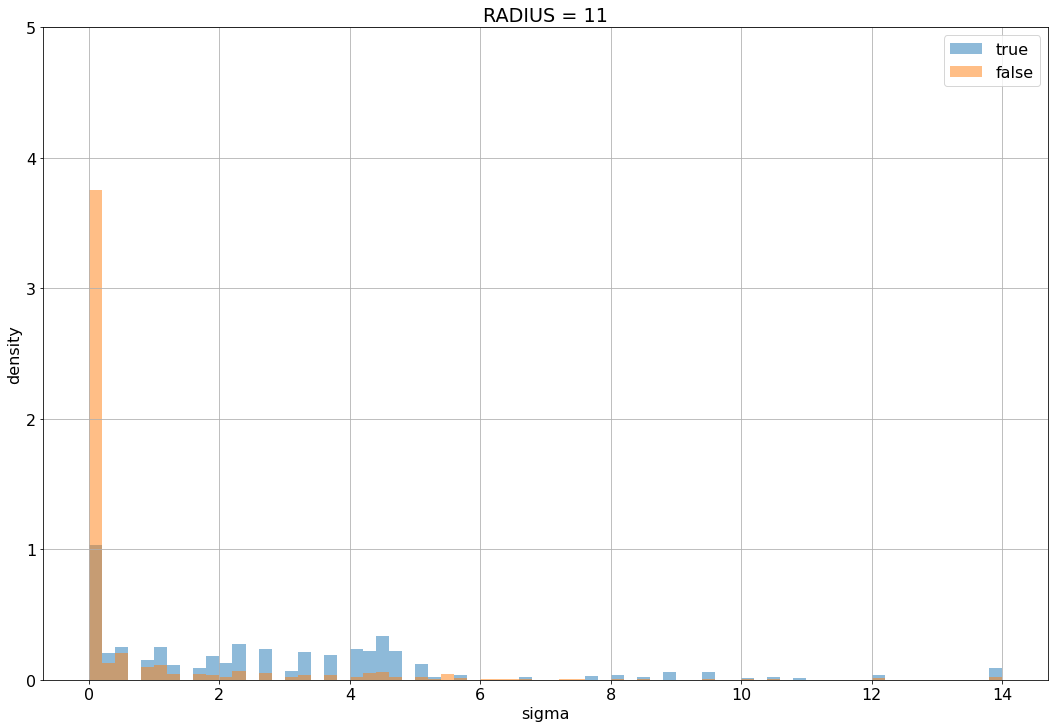

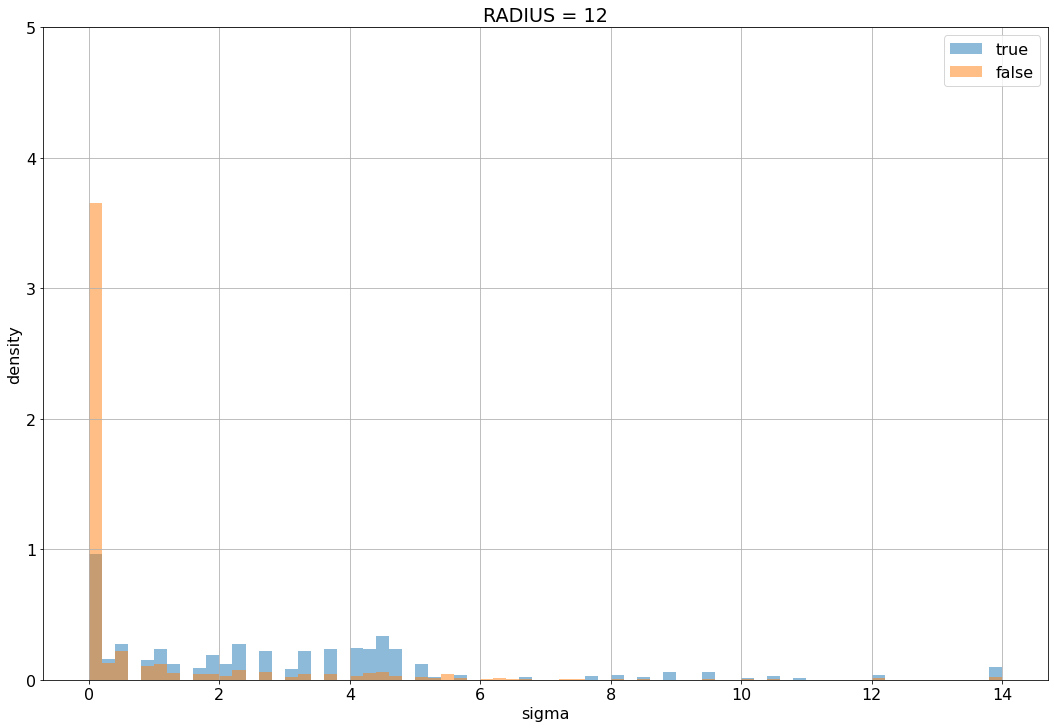

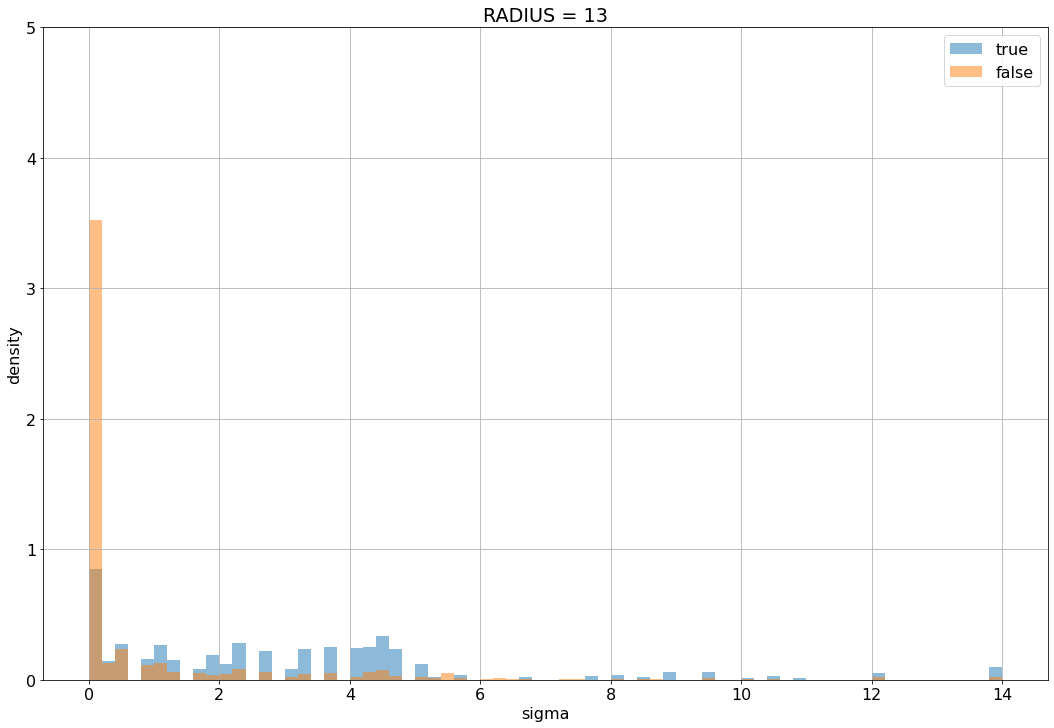

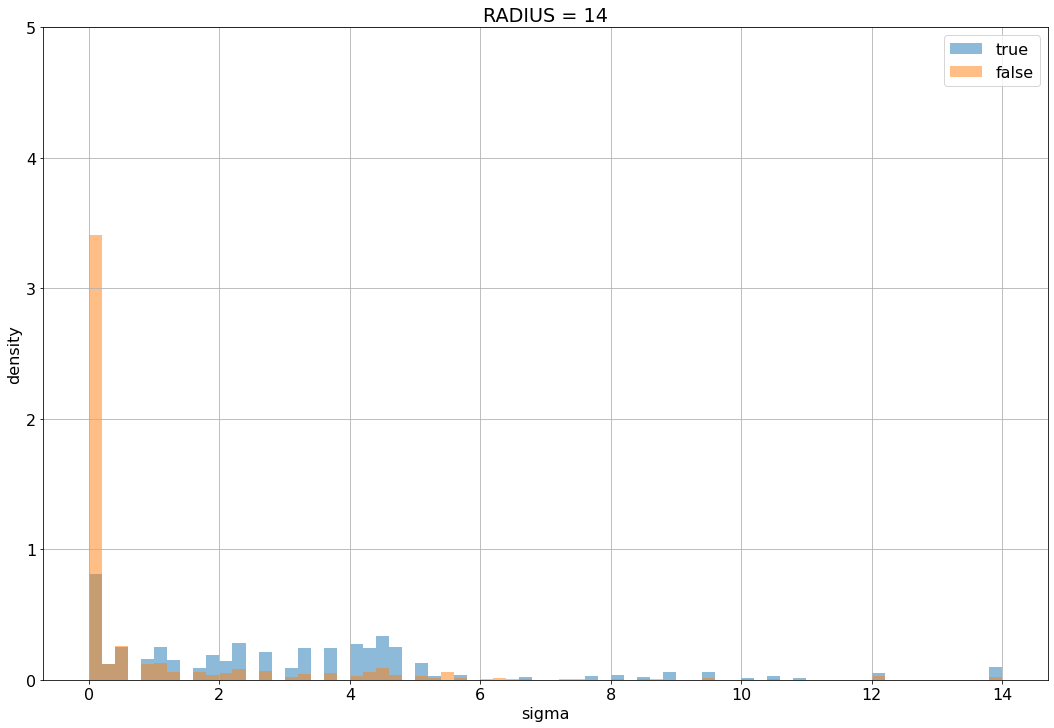

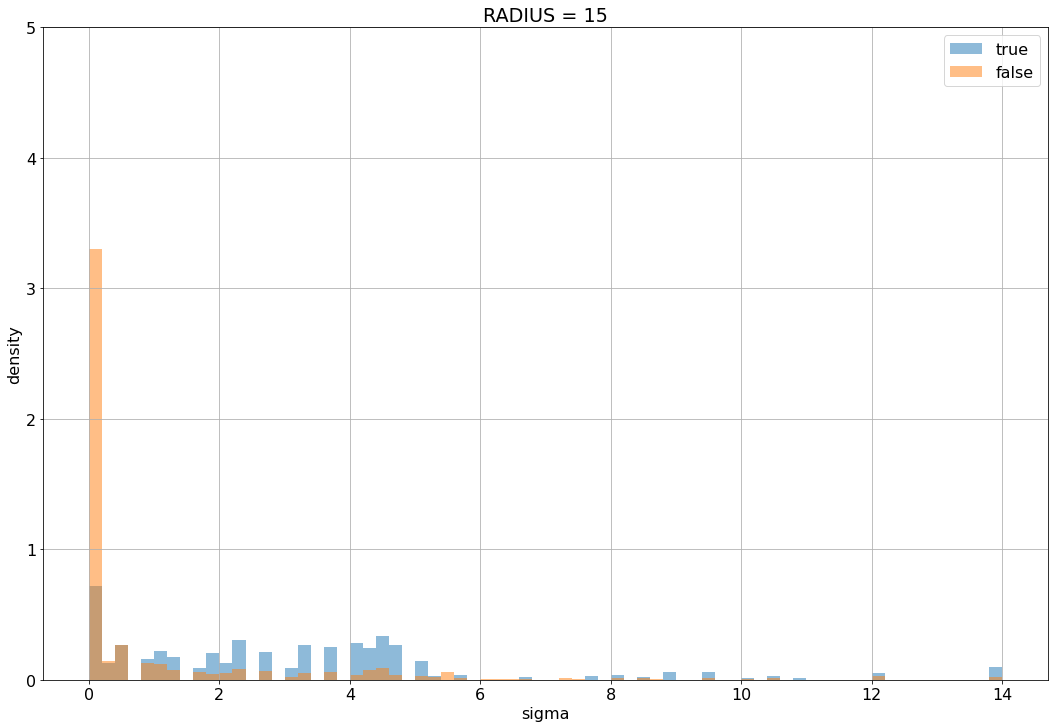

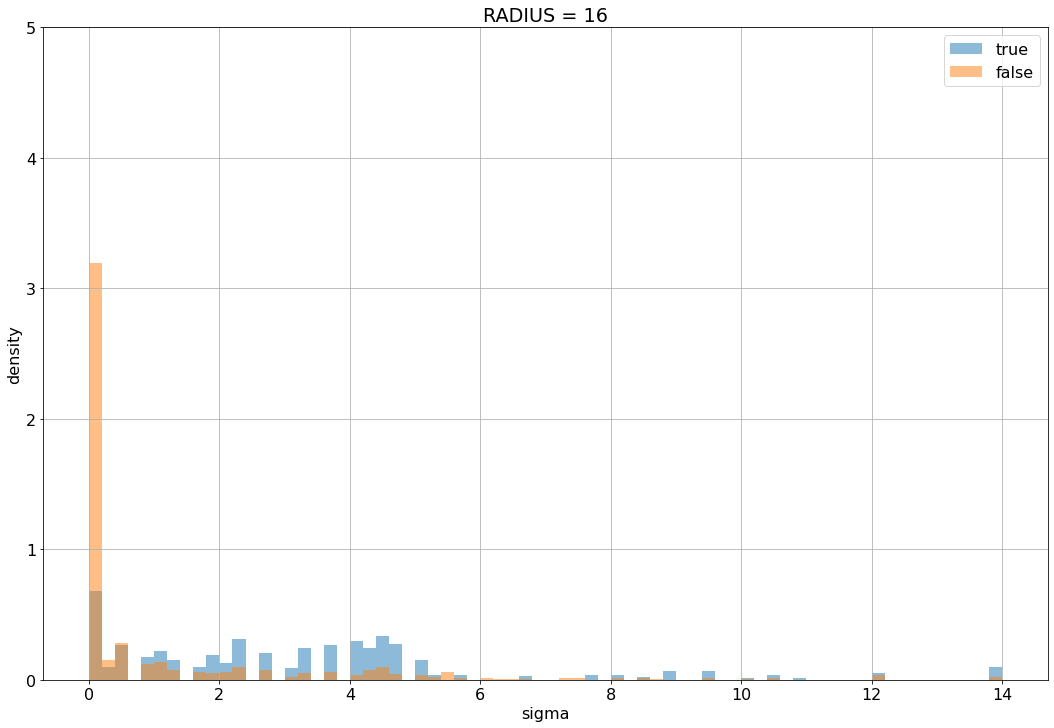

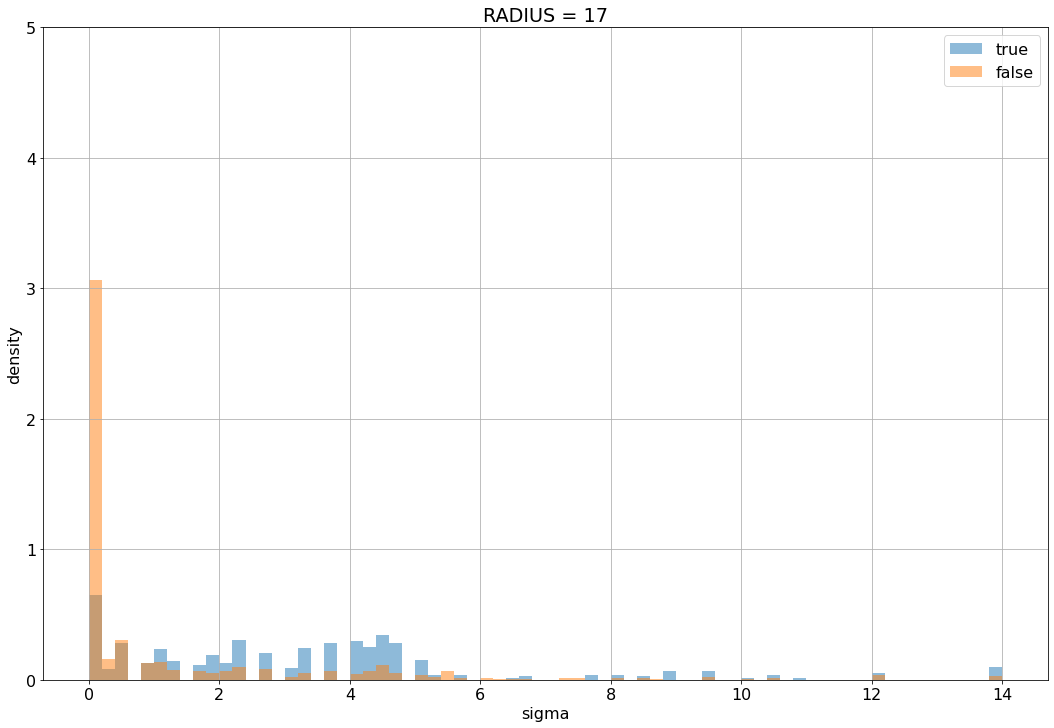

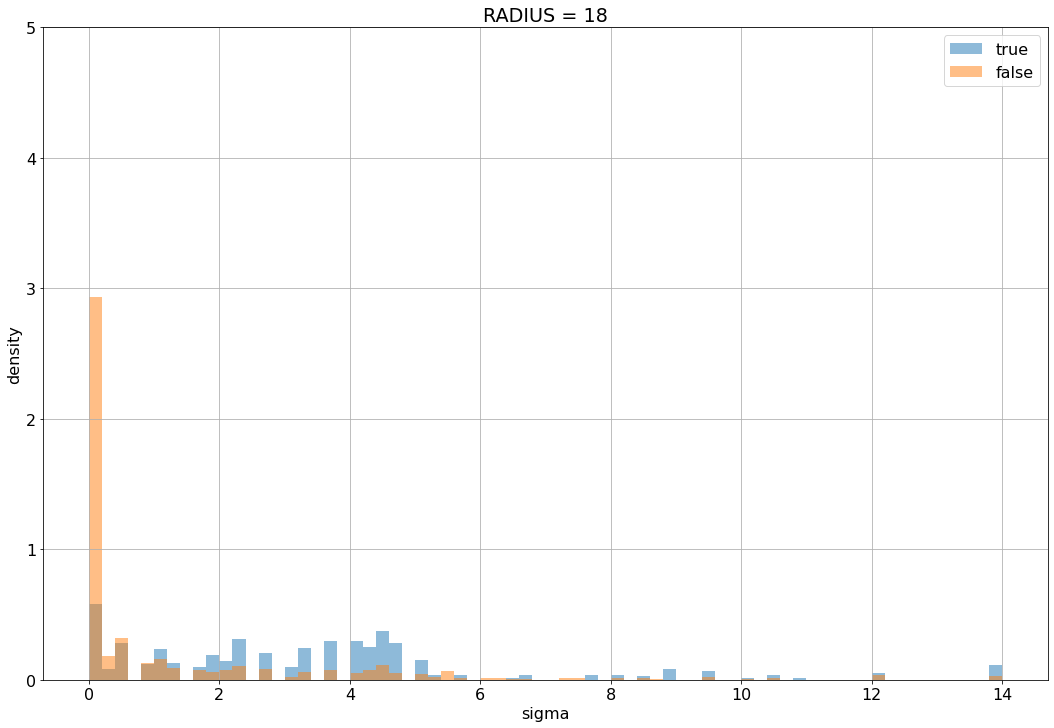

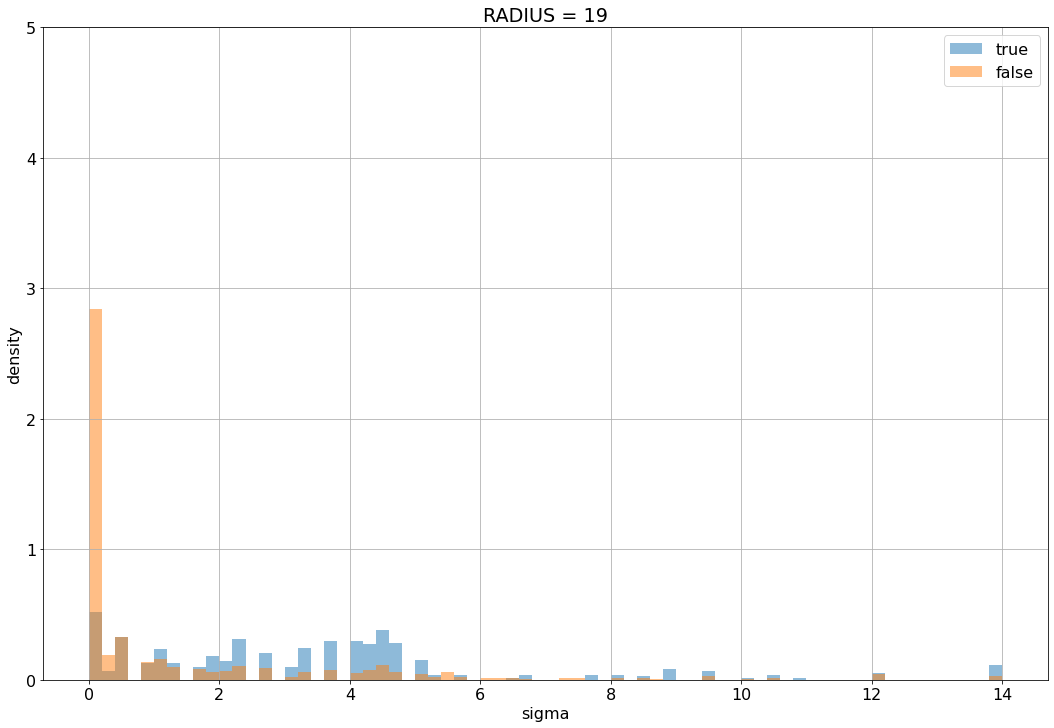

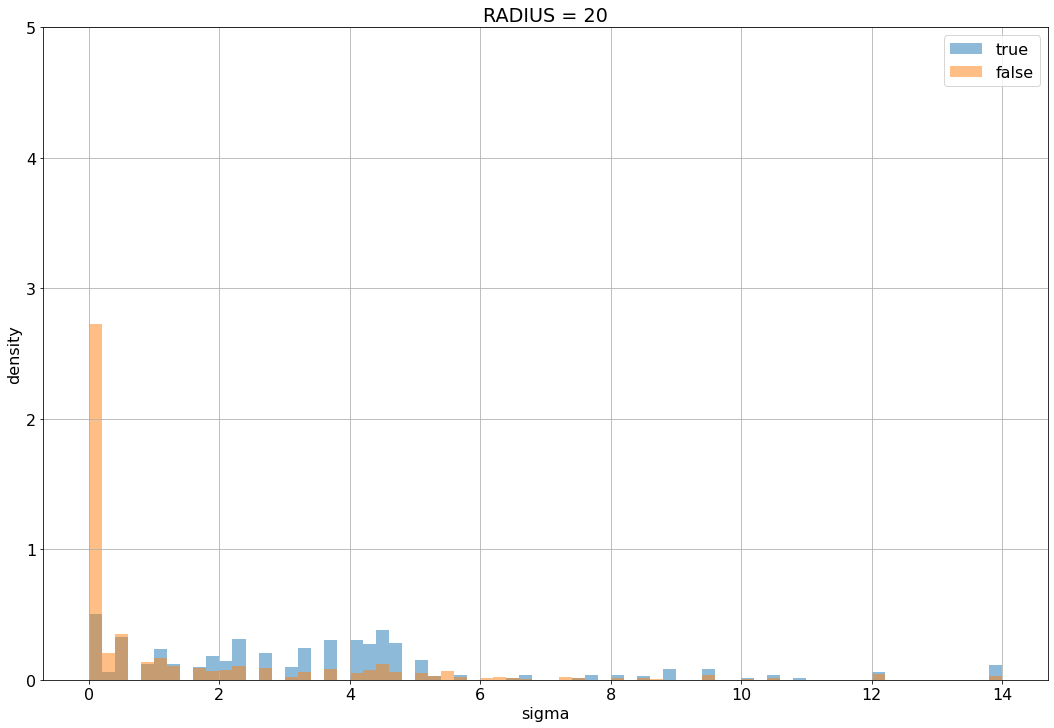

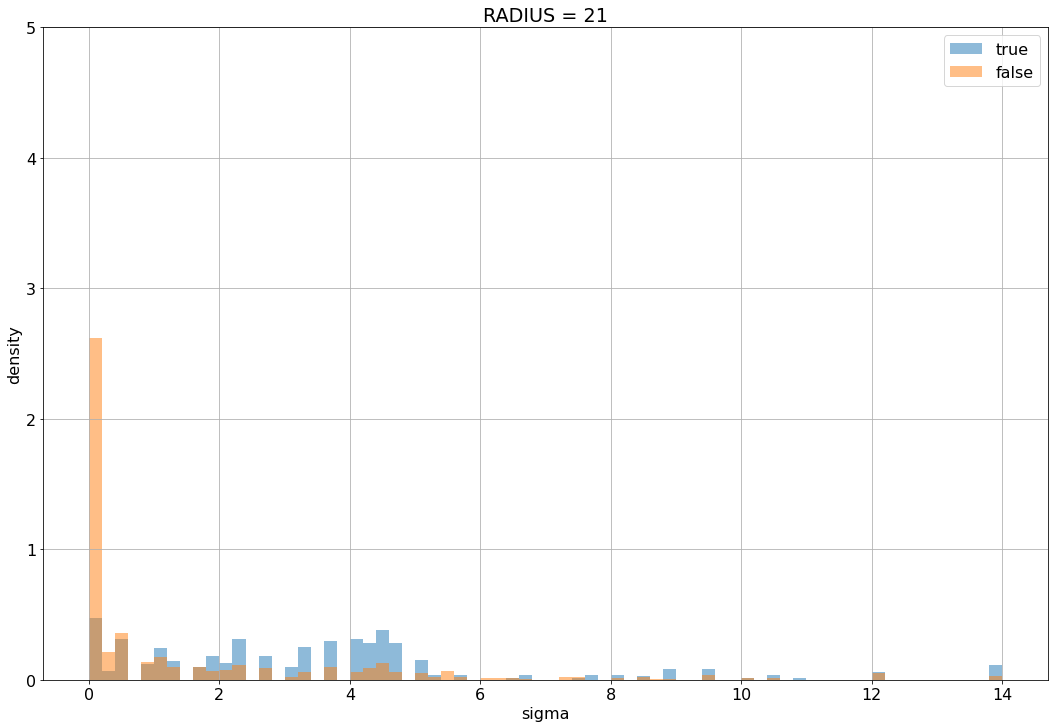

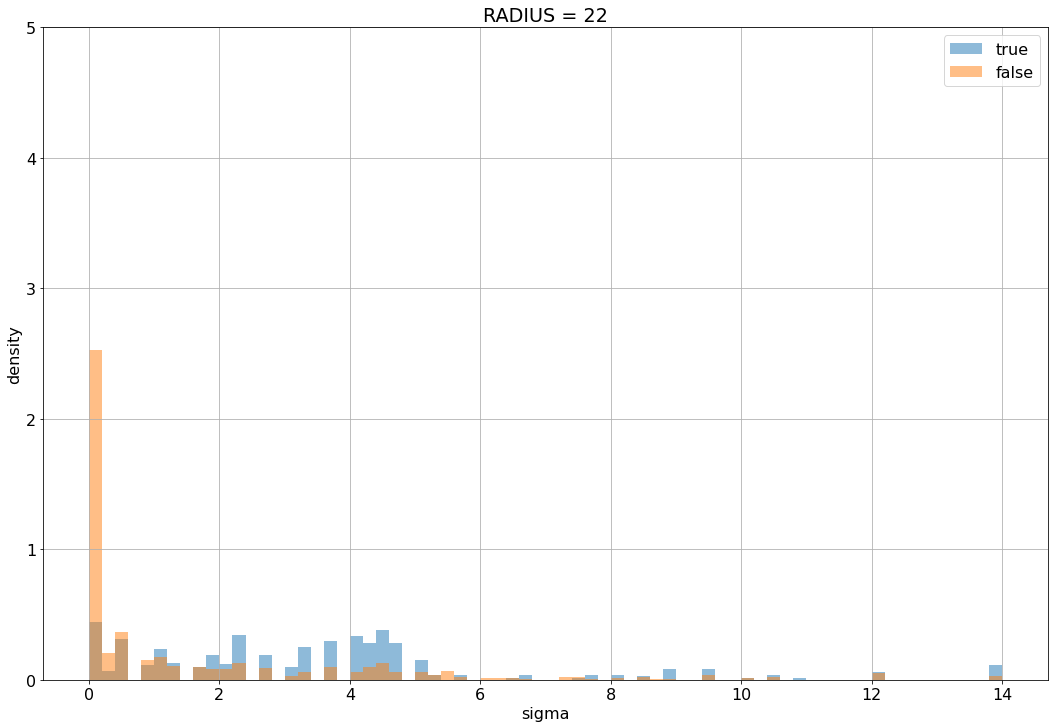

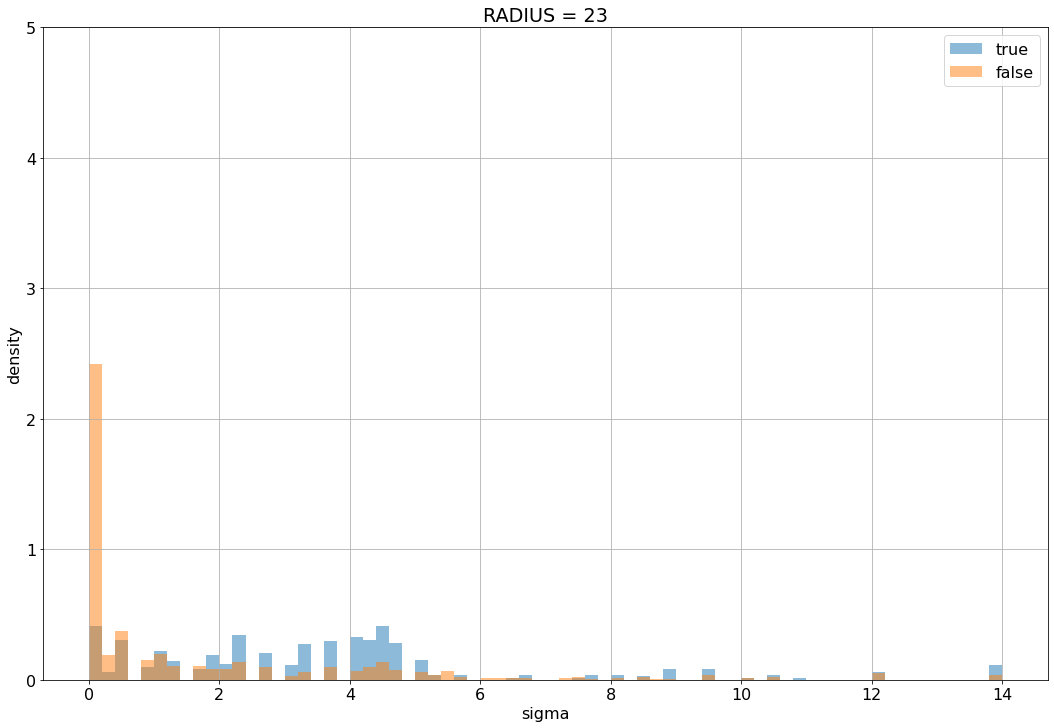

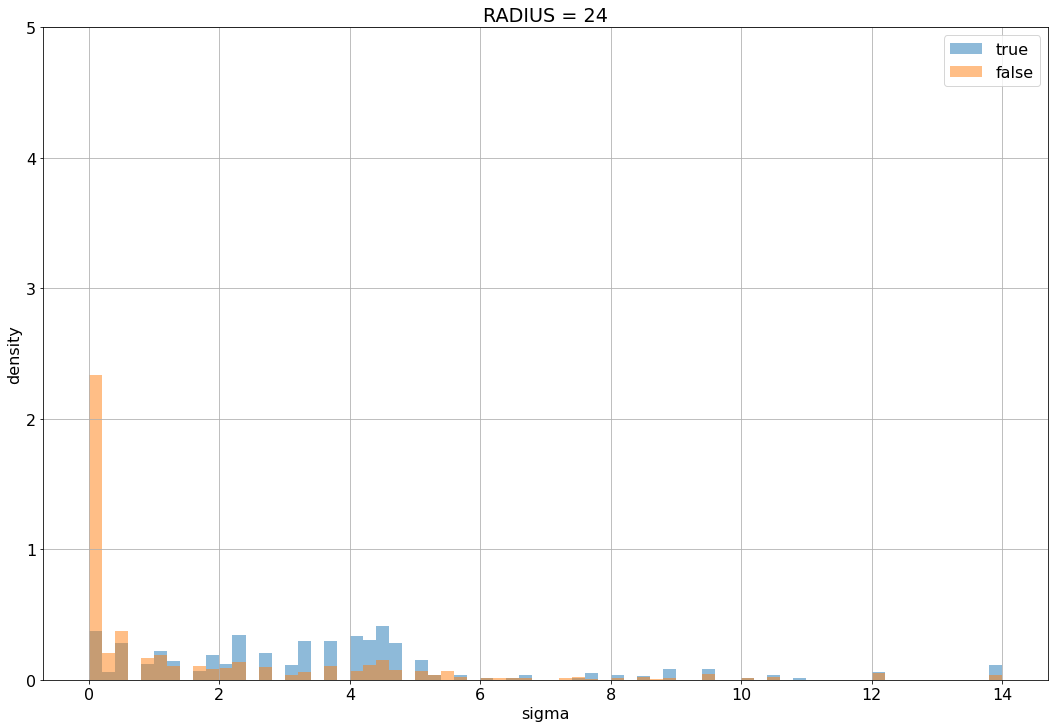

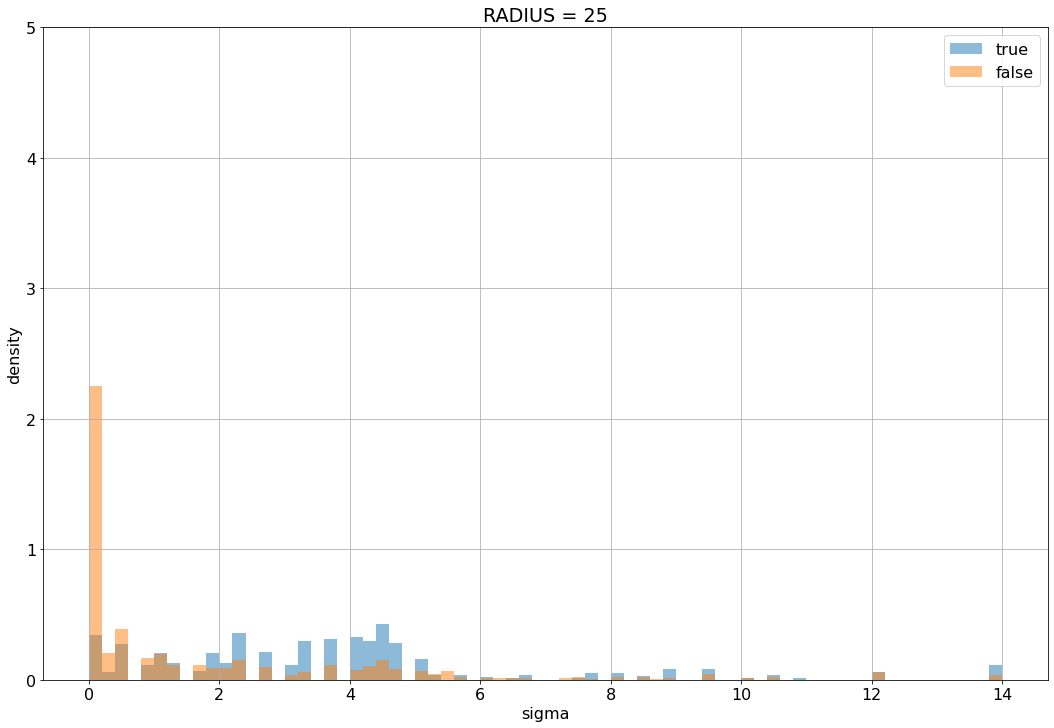

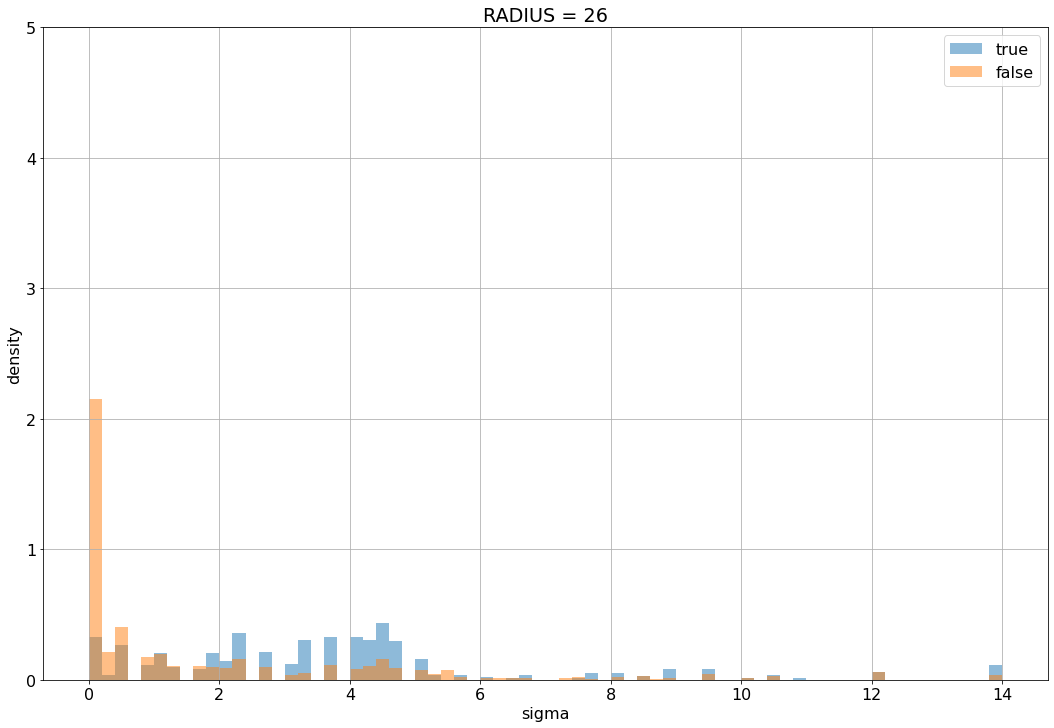

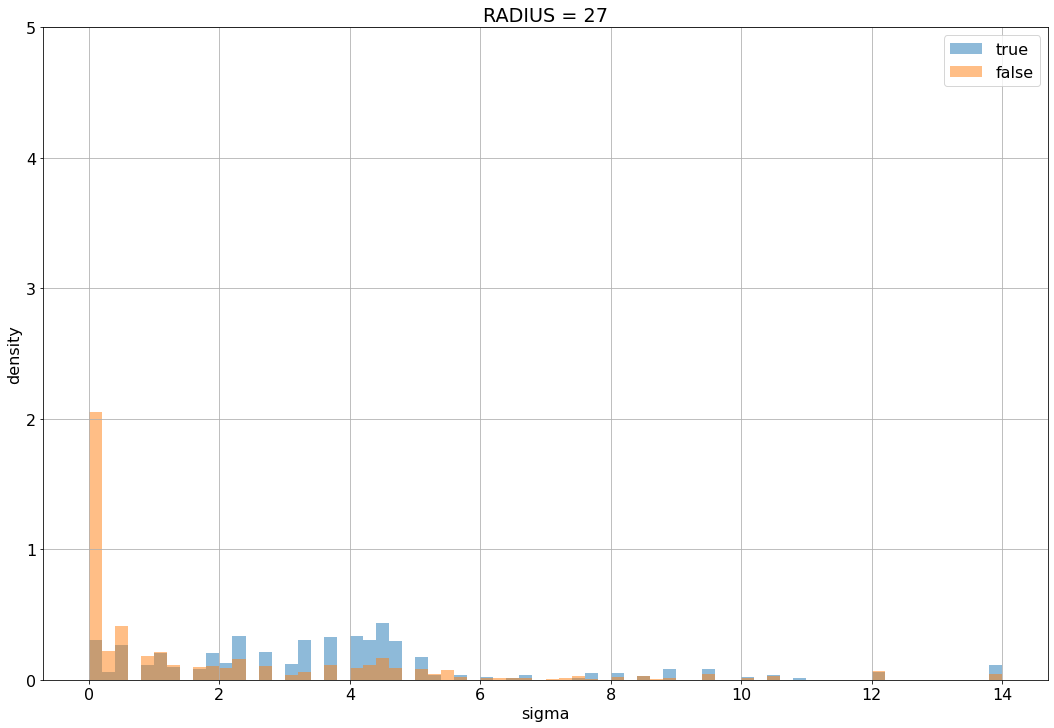

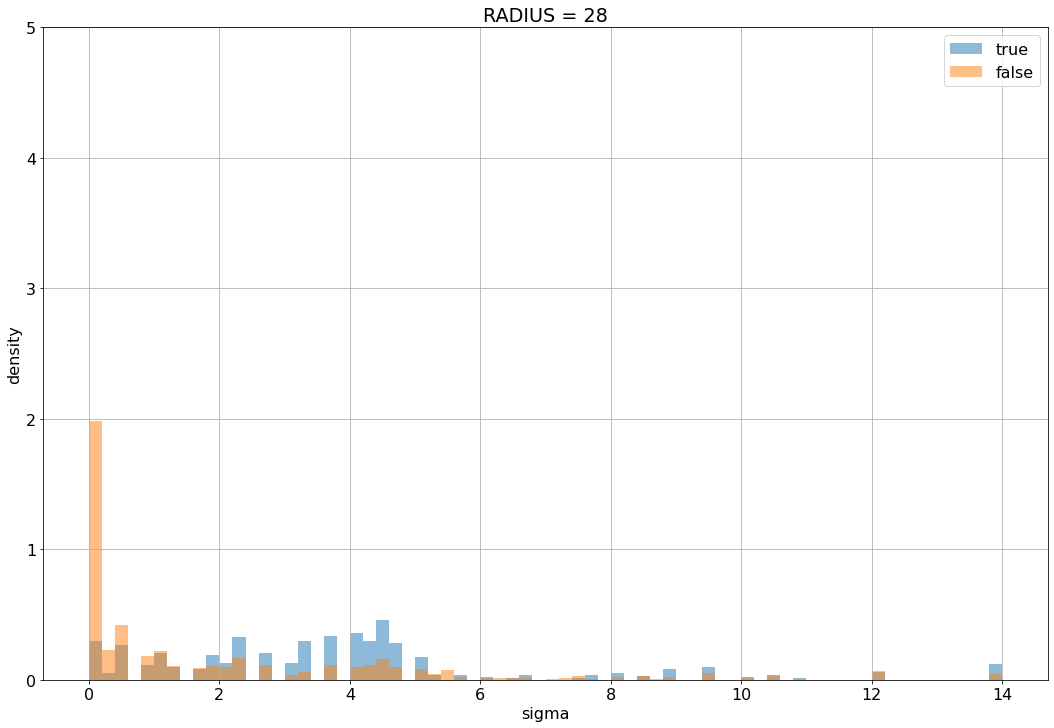

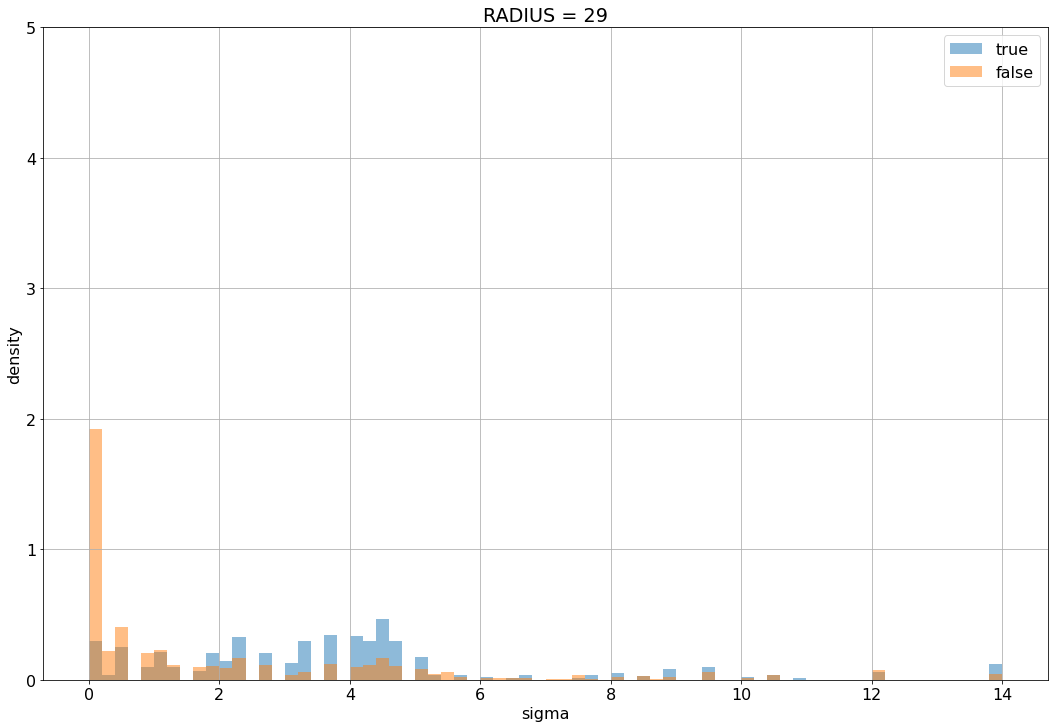

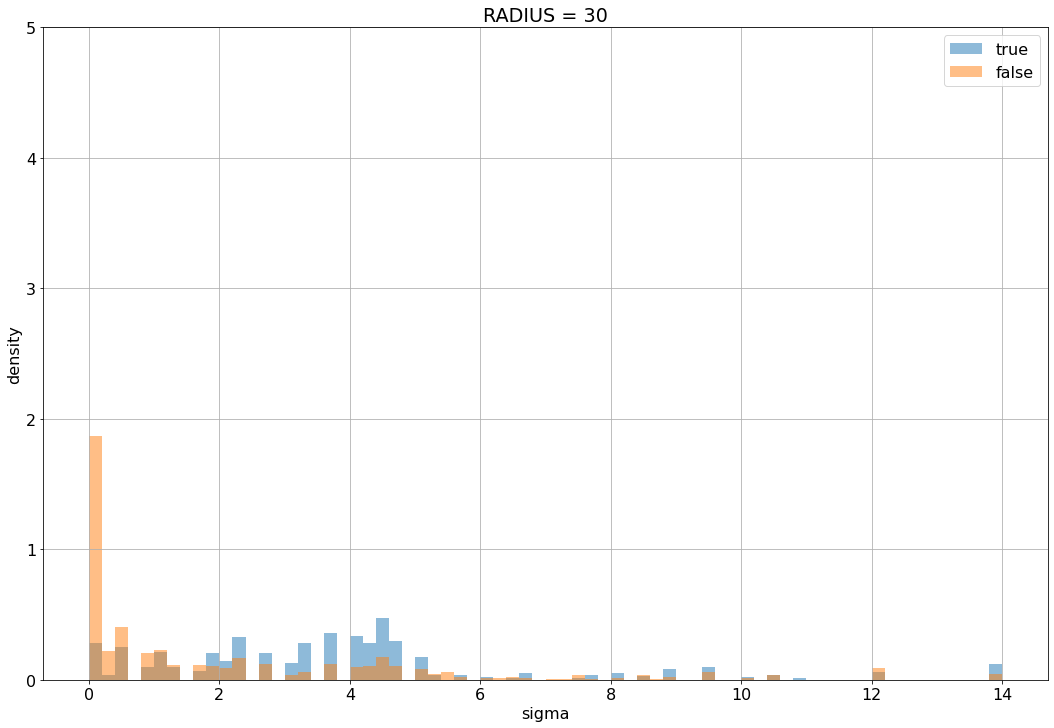

In [17]:
for i, rad in enumerate(rads):
    font = {'size': 16}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(18, 12))
    plt.grid()
#     plt.xlim((0, 8))
    plt.ylim((0, 5))
    
    plt.hist(sigma_scores[:TRUE_CL_NUM, i], density=True, stacked=True, bins=70, alpha=0.5, label='true', range=(0, 14))
    plt.hist(sigma_scores[TRUE_CL_NUM:, i], density=True, stacked=True, bins=70, alpha=0.5, label='false', range=(0, 14))
    plt.xlabel('sigma')
    plt.ylabel('density')
    plt.legend()
    plt.title(f'RADIUS = {rad}')
    plt.savefig(f'hists/RADIUS={rad}.jpg')

In [18]:
X = np.concatenate((dists, train_clusters['Z'].values.reshape(-1, 1)), axis=1)
Y = train_clusters['type'].values

In [19]:
X.shape

(3493, 71)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, stratify=Y, test_size=0.25
)

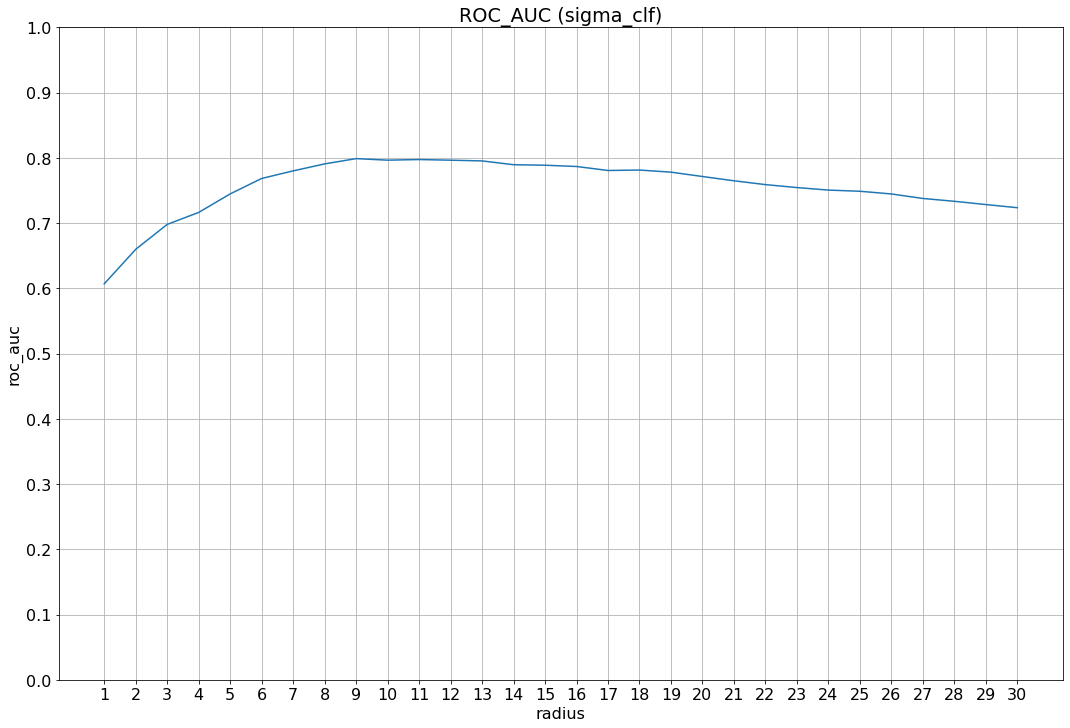

In [21]:
sigmas_roc_aucs = []
for i in range(len(rads)):
    sigmas_roc_aucs.append(roc_auc_score(Y, sigma_scores[:, i]))

font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.xticks(rads)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim((0, 1))

plt.plot(rads, sigmas_roc_aucs)

    
plt.xlabel('radius')
plt.ylabel('roc_auc')
plt.title(f'ROC_AUC (sigma_clf)')
plt.savefig(f'ROC_AUC (sigma_clf).jpg')

In [22]:
max(sigmas_roc_aucs), np.argmax(sigma_scores) + 1

(0.7989665314401622, 1591)

In [23]:
logreg = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, Y_train)
logreg_scores = logreg.predict_proba(X_test)[:,1].reshape(-1)

In [24]:
roc_auc_score(Y_test, logreg_scores)

0.8773667630151668

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len(sigmas)+1, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        out = F.sigmoid(x)
        return out

In [27]:
torch.manual_seed(0)
net = Net()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(),lr=0.001)
number_of_epochs = 6000
for epoch in range(number_of_epochs):
    Y_pred = net(torch.Tensor(X_train))
    loss = criterion(Y_pred, torch.Tensor(Y_train).view(-1, 1))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%200 == 0:
        Y_pred = net(torch.Tensor(X_test))
        test_loss = criterion(Y_pred, torch.Tensor(Y_test).view(-1, 1))
        print(f'epoch: {epoch+1}, train_loss={loss.item()}, test_loss={test_loss}')

/home/svasilyev/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 200, train_loss=12.51480770111084, test_loss=12.725767135620117
epoch: 400, train_loss=12.503149032592773, test_loss=12.685688018798828
epoch: 600, train_loss=0.42413780093193054, test_loss=0.41457197070121765
epoch: 800, train_loss=0.34350061416625977, test_loss=0.33215421438217163
epoch: 1000, train_loss=0.3330851197242737, test_loss=0.32359036803245544
epoch: 1200, train_loss=0.3267775774002075, test_loss=0.31890055537223816
epoch: 1400, train_loss=0.3218947947025299, test_loss=0.3151475191116333
epoch: 1600, train_loss=0.31726571917533875, test_loss=0.31211915612220764
epoch: 1800, train_loss=0.3131849765777588, test_loss=0.30915772914886475
epoch: 2000, train_loss=0.3093486428260803, test_loss=0.30703336000442505
epoch: 2200, train_loss=0.30695778131484985, test_loss=0.3055056035518646
epoch: 2400, train_loss=0.3037838935852051, test_loss=0.3039499819278717
epoch: 2600, train_loss=0.3004075586795807, test_loss=0.3027270436286926
epoch: 2800, train_loss=0.2971896827220917, t

In [28]:
net_scores = net(torch.Tensor(X_test)).view(-1).detach().numpy()
roc_auc_score(Y_test, net_scores)

0.8740432810453271

In [29]:
rf = RandomForestClassifier(
    max_depth=10, 
    random_state=0,
    n_estimators=500,
    max_features=None
).fit(X_train, Y_train)
rf_scores = rf.predict_proba(X_test)[:,1].reshape(-1)
roc_auc_score(Y_test, rf_scores)

0.9120738744005283

In [30]:
boosting = lgbm.LGBMClassifier(
    boosting_type='gbdt', objective='binary',
    learning_rate=0.01, n_estimators=200,
    max_depth=10, bagging_fraction=1.0,
    reg_lambda=0.2
).fit(X_train, Y_train)
boosting_scores = boosting.predict_proba(X_test)[:,1].reshape(-1)
roc_auc_score(Y_test, boosting_scores)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


0.9137626795708702

In [31]:
test_clusters['ID'] = list(range(1, test_clusters.shape[0]+1))
test_clusters

,RA,DEC,Z,M,R,ID
0,230.761495,8.587807,0.035200,1.676978,0,1
1,217.958949,13.531505,0.159770,1.672366,0,2
2,221.662409,17.849673,0.200000,2.159093,0,3
3,194.112418,4.674226,0.230702,3.048494,0,4
4,201.756210,2.203833,0.260000,4.595230,0,5
5,233.943396,0.066695,0.295000,2.186019,0,6
6,217.243121,1.744618,0.317215,3.075904,0,7
7,225.037556,6.820814,0.334927,1.533393,0,8
8,185.157410,13.602676,0.349000,1.822679,0,9
9,235.816492,7.961940,0.360000,3.941155,0,10


In [32]:
z = [round(i, 4) for i in np.arange(0.002, 1.0, 0.002)]
ID, RA, DEC, Z, Z_true, M, R = [], [], [], [], [], [], []
for i in range(test_clusters.shape[0]):
    row = test_clusters.iloc[i]
    ID = ID + [int(row['ID'])] * len(z)
    RA = RA + [row['RA']] * len(z)
    DEC = DEC + [row['DEC']] * len(z)
    Z = Z + z.copy()
    Z_true = Z_true + [row['Z']] * len(z)
#     TYPE = TYPE + [int(row['TYPE'])] * len(z)
    M = M + [row['M']] * len(z)
    R = R + [row['R']] * len(z)
CX, CY, CZ = util_DPS.sph2cart(RA, DEC, Z)
len(ID)

12974

In [33]:
test_clusters_ext = pd.DataFrame({
    'ID': ID, 'RA': RA, 'DEC': DEC, 'Z': Z,
    'CX': CX, 'CY': CY, 'CZ': CZ,
    'Z_true': Z_true, 'M': M, 'R': R
})
test_clusters_ext

,ID,RA,DEC,Z,CX,CY,CZ,Z_true,M,R
0,1,230.761495,8.587807,0.002,-5.531095,-6.772495,1.320521,0.035200,1.676978,0.0
1,1,230.761495,8.587807,0.004,-11.057085,-13.538739,2.639823,0.035200,1.676978,0.0
2,1,230.761495,8.587807,0.006,-16.577964,-20.298725,3.957905,0.035200,1.676978,0.0
3,1,230.761495,8.587807,0.008,-22.093726,-27.052446,5.274765,0.035200,1.676978,0.0
4,1,230.761495,8.587807,0.010,-27.604365,-33.799893,6.590403,0.035200,1.676978,0.0
...,...,...,...,...,...,...,...,...,...,...
12969,26,167.720933,2.283333,0.990,-3293.461273,716.830291,134.393991,0.741584,2.187525,0.0
12970,26,167.720933,2.283333,0.992,-3298.354122,717.895232,134.593650,0.741584,2.187525,0.0
12971,26,167.720933,2.283333,0.994,-3303.241242,718.958926,134.793076,0.741584,2.187525,0.0
12972,26,167.720933,2.283333,0.996,-3308.122641,720.021375,134.992268,0.741584,2.187525,0.0


In [34]:
f_name = 'ACT_03_test_dists_ext.npy'
if os.path.exists(f_name):
    with open(f_name, 'rb') as f:
        test_dists_ext = np.load(f)
else:
    test_dists_ext = []
    for sigma in tqdm(sigmas):
        DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')

        _, _, cl_dists \
            = DPS.count_conn(test_clusters_ext['R'], test_clusters_ext)
        test_dists_ext.append(np.array(cl_dists)[None,:])
    test_dists_ext = np.concatenate(test_dists_ext, axis=0)
    test_dists_ext = test_dists_ext.T
    with open(f_name, 'wb') as f:
        np.save(f, test_dists_ext)
    
test_dists_ext.shape

(12974, 70)

In [35]:
test_ext_sigma_scores = []
for i, rad in tqdm(enumerate(rads)):
    s = np.zeros(test_clusters_ext.shape[0])
    for j, sigma in enumerate(sigmas):
        s[test_dists_ext[:,j] <= rad] = sigma
    test_ext_sigma_scores.append(s)
    
test_ext_sigma_scores = np.array(test_ext_sigma_scores).T
test_ext_sigma_scores.shape

30it [00:00, 1079.95it/s]


(12974, 30)

In [36]:
X_test_ext = np.concatenate(
    (test_dists_ext, test_clusters_ext['Z'].values.reshape(-1, 1)),
    axis=1
)
test_ext_rf_scores = rf.predict_proba(X_test_ext)[:,1].reshape(-1)
test_ext_boosting_scores = boosting.predict_proba(X_test_ext)[:,1].reshape(-1)
test_ext_rf_scores.shape, test_ext_boosting_scores.shape

((12974,), (12974,))

In [37]:
for i, rad in enumerate(rads):
    test_clusters_ext[f'sigma_{rad}_score'] = test_ext_sigma_scores[:, i]
test_clusters_ext[f'rf_score'] =  test_ext_rf_scores
test_clusters_ext[f'boosting_score'] =  test_ext_boosting_scores

<ipython-input-49-984471ccd605>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20, 8))


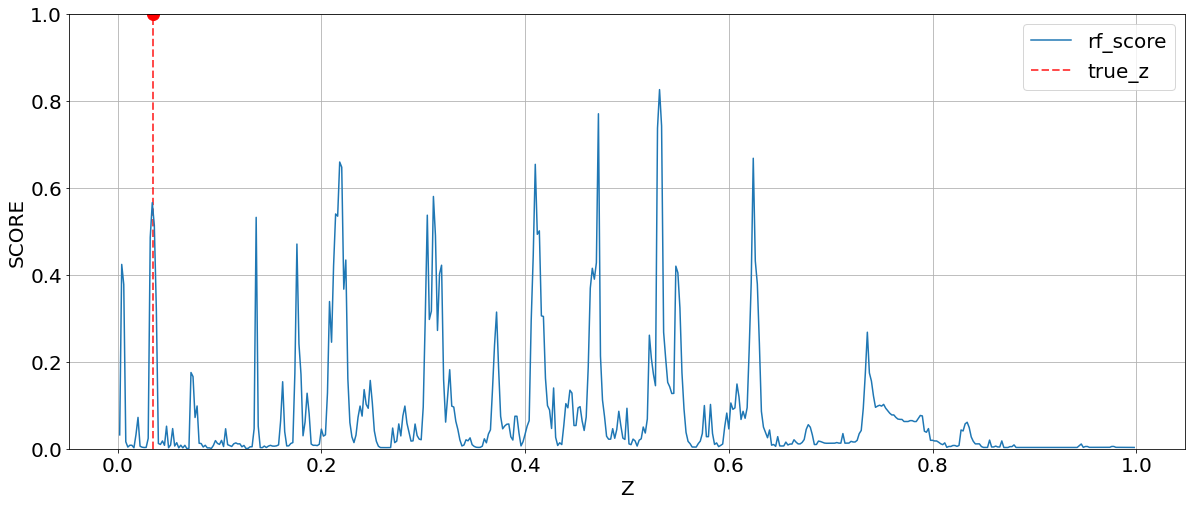

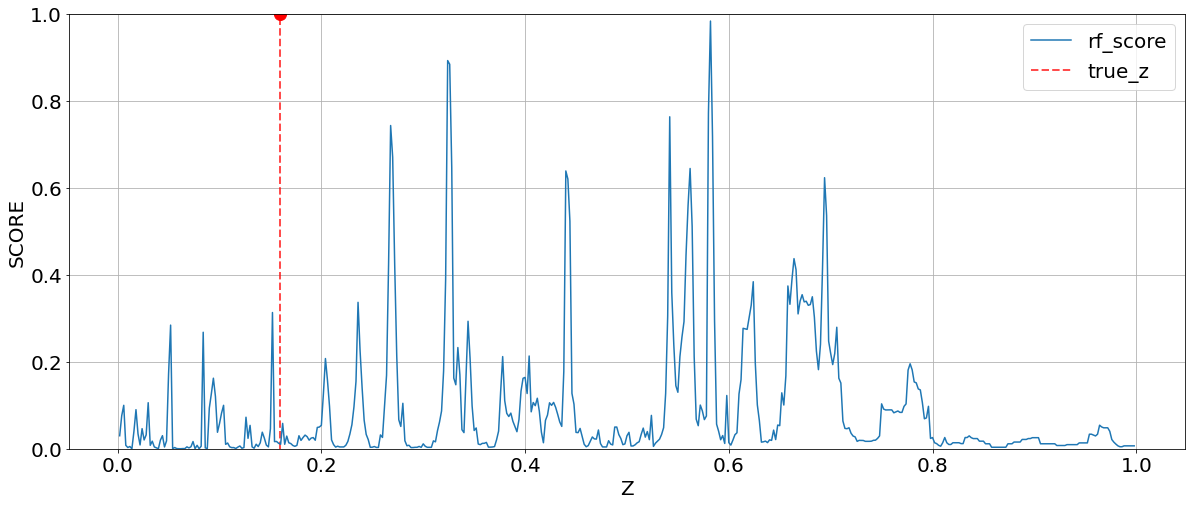

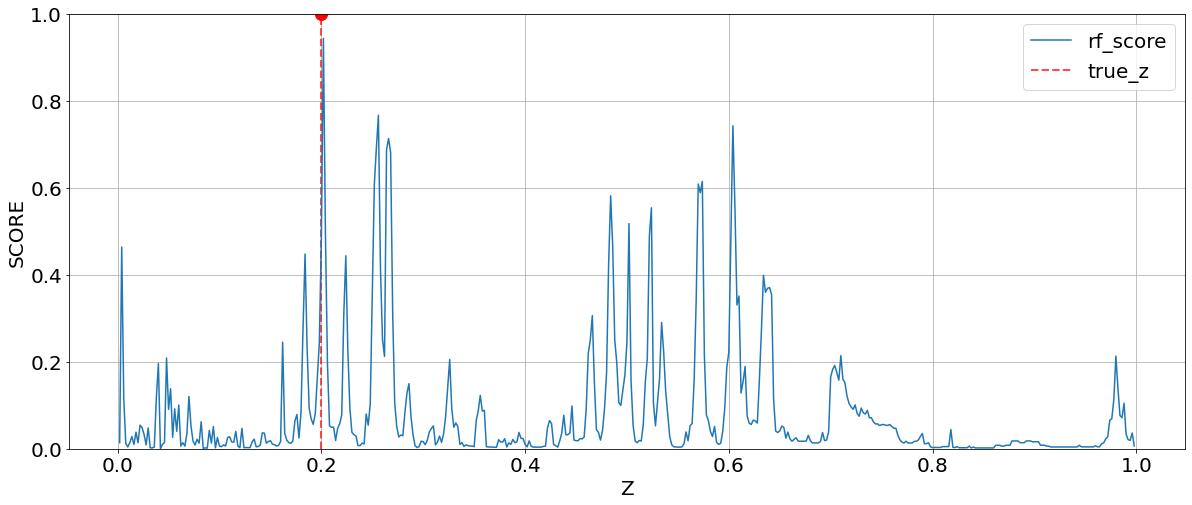

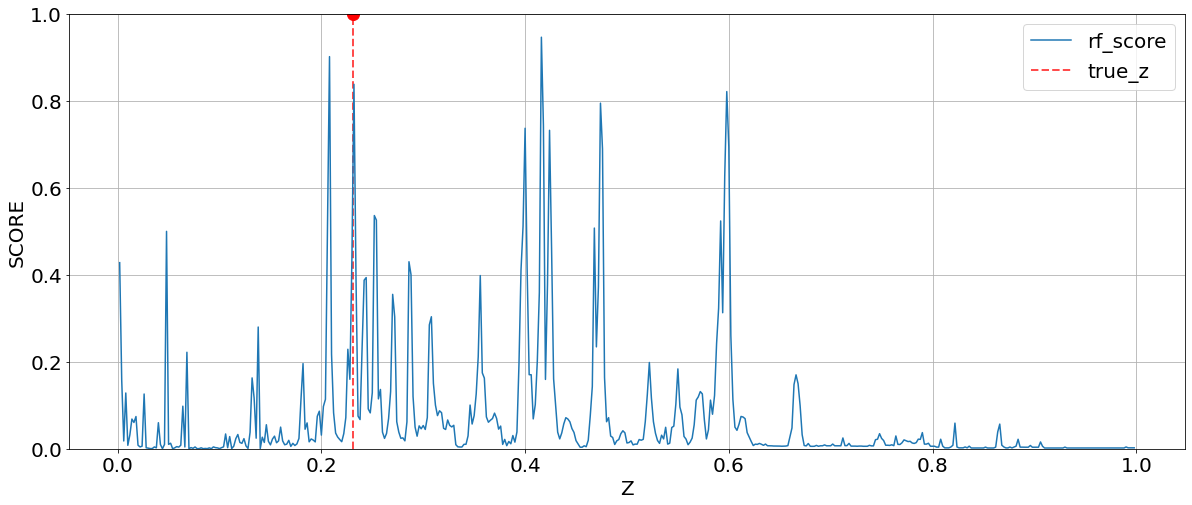

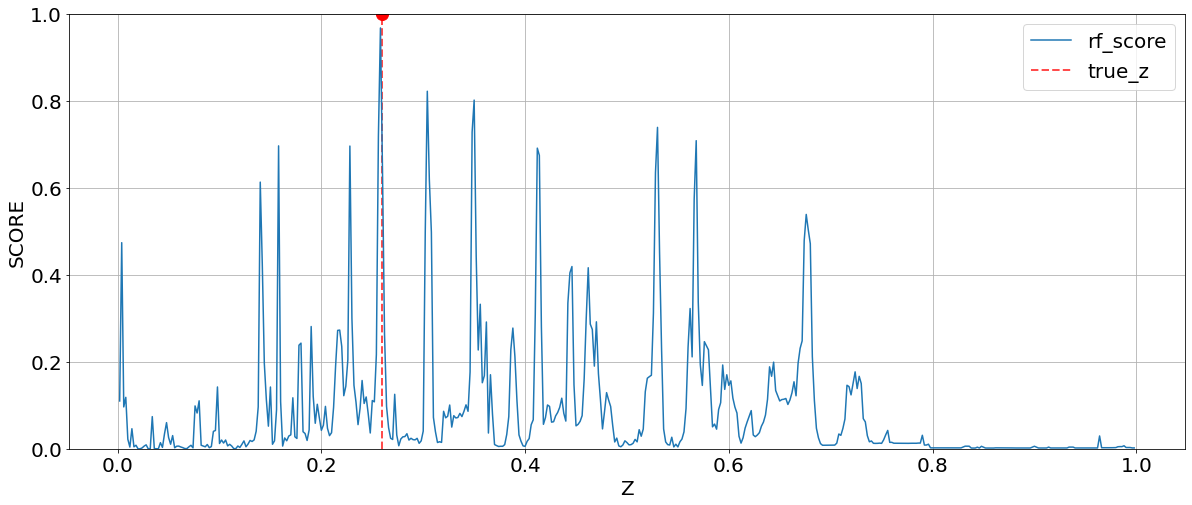

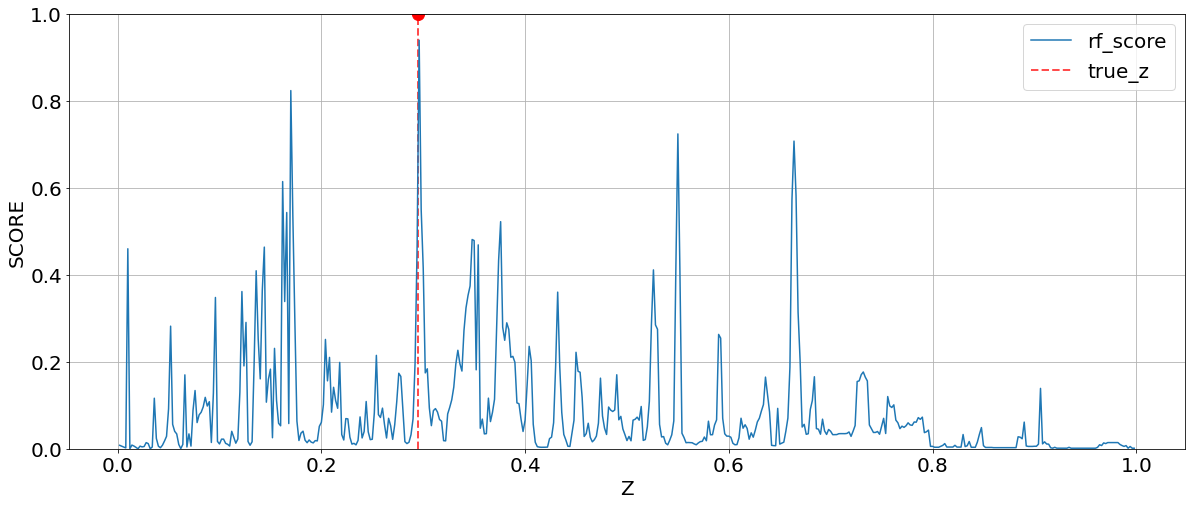

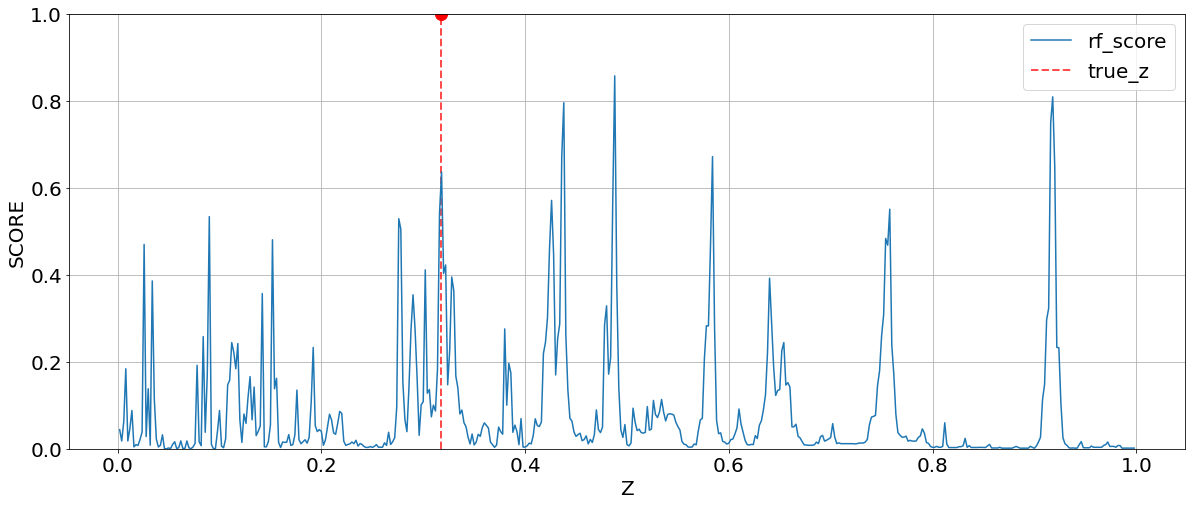

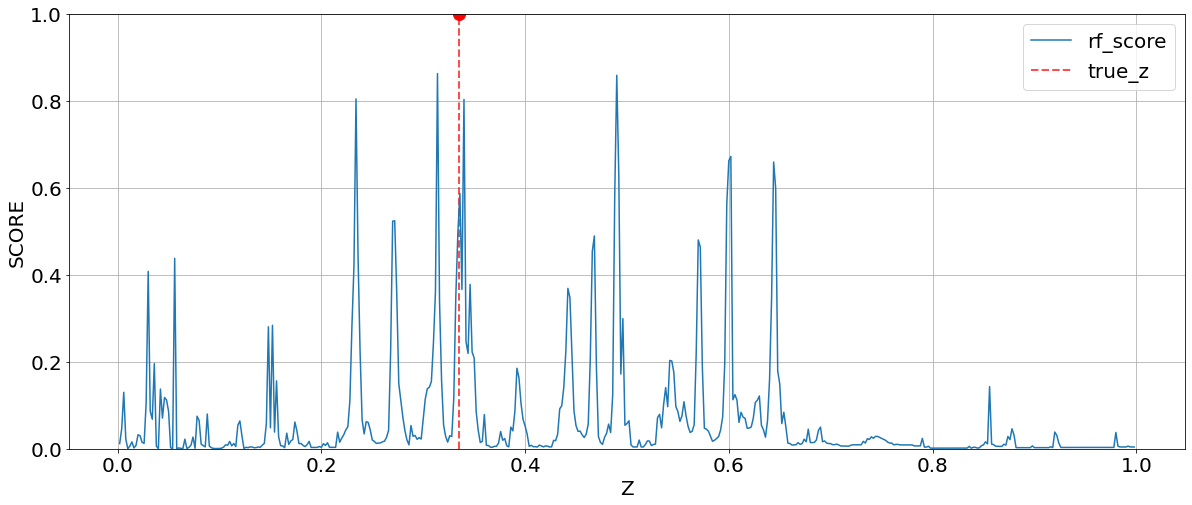

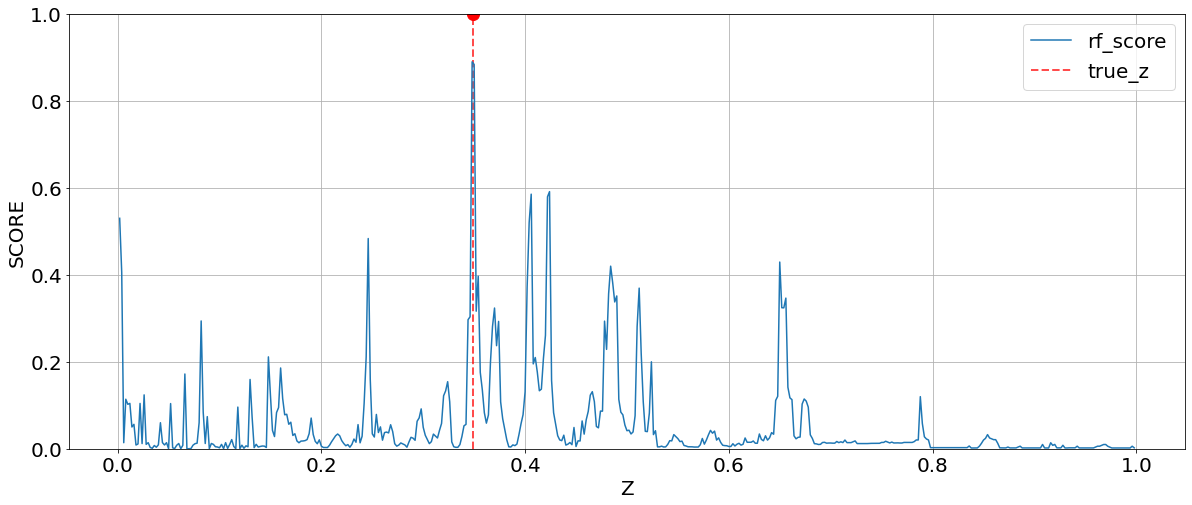

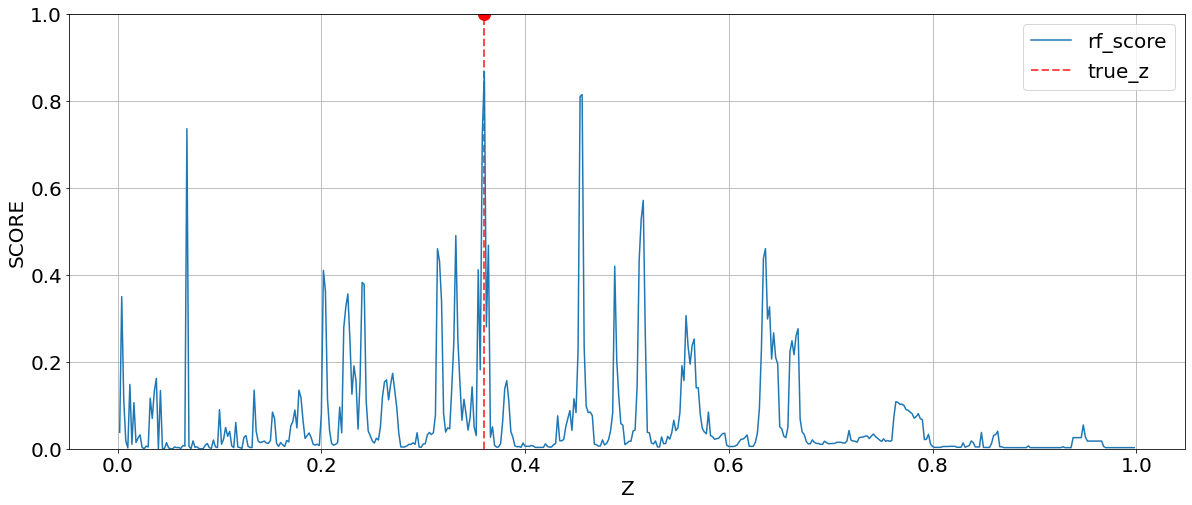

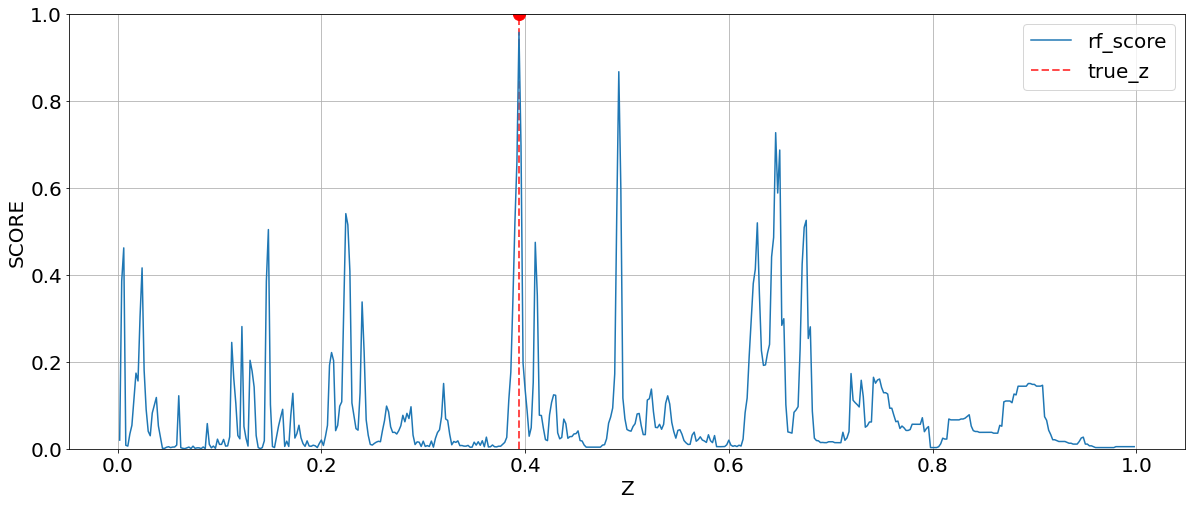

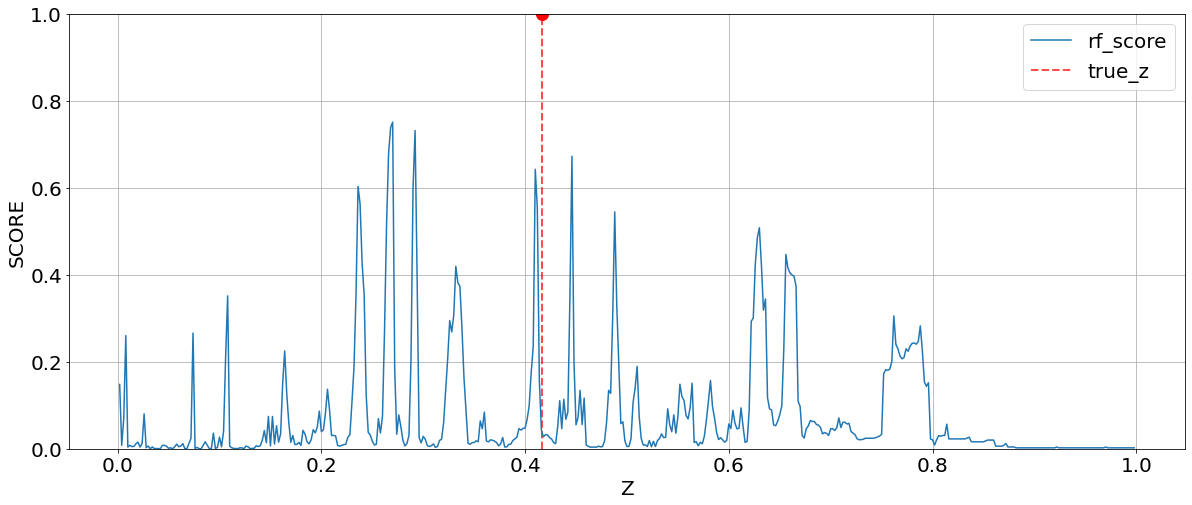

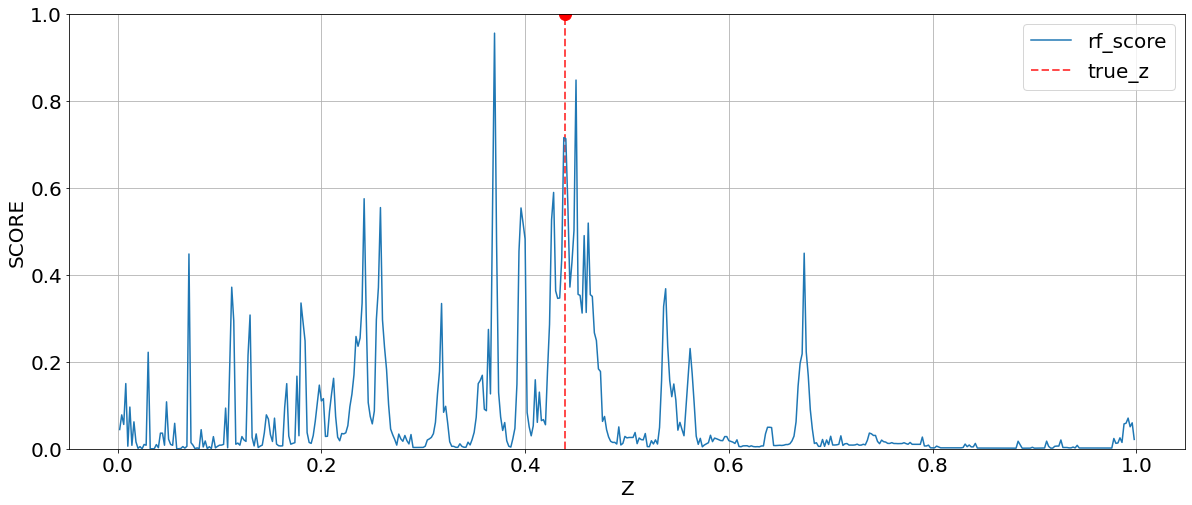

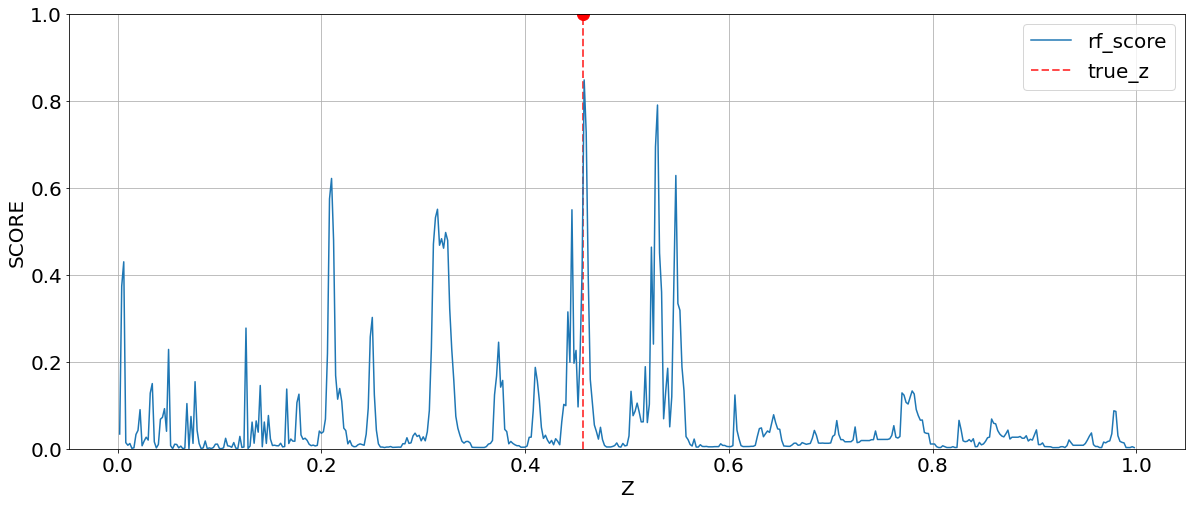

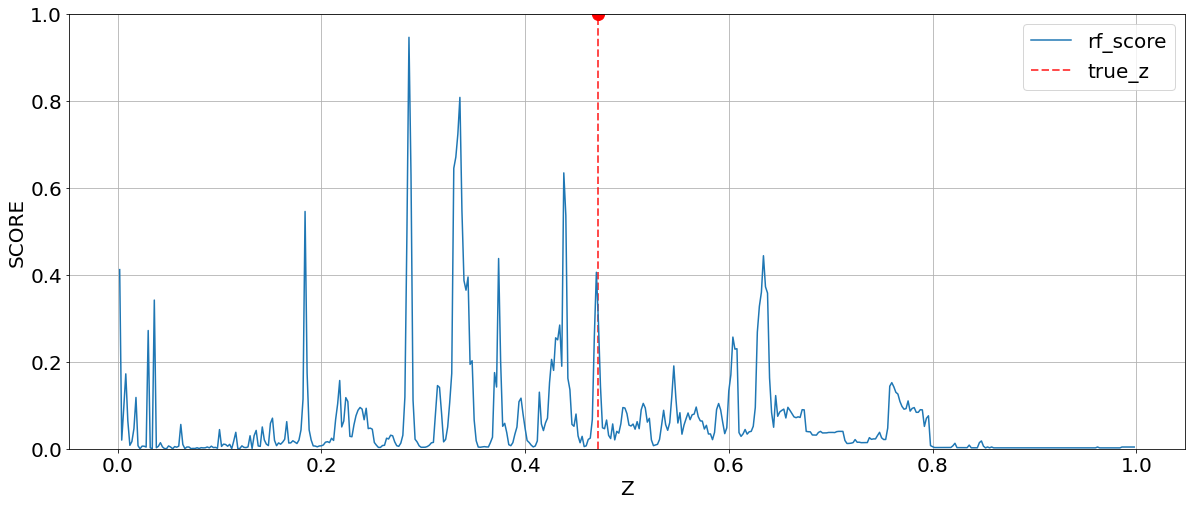

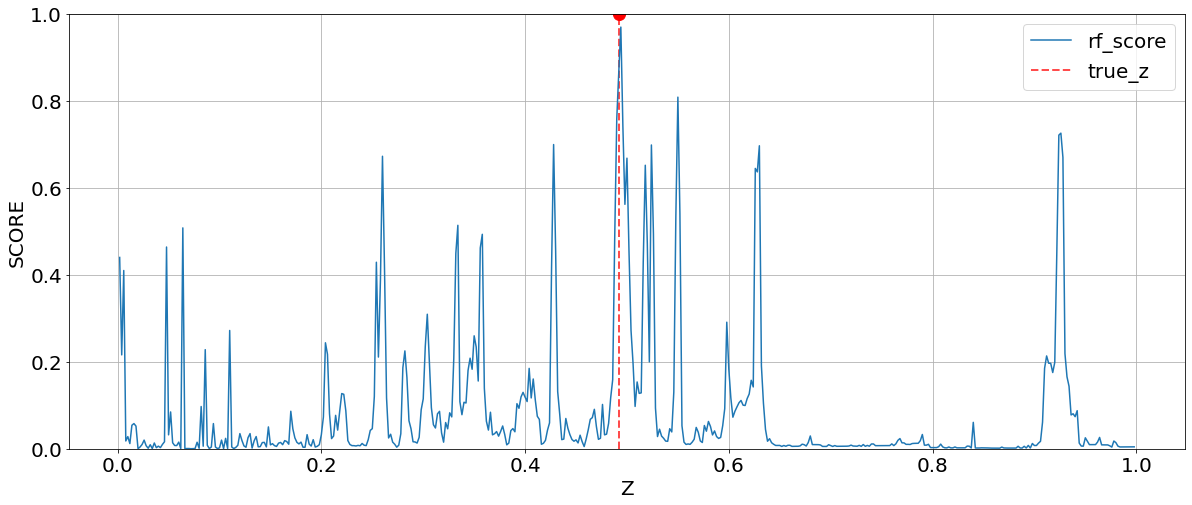

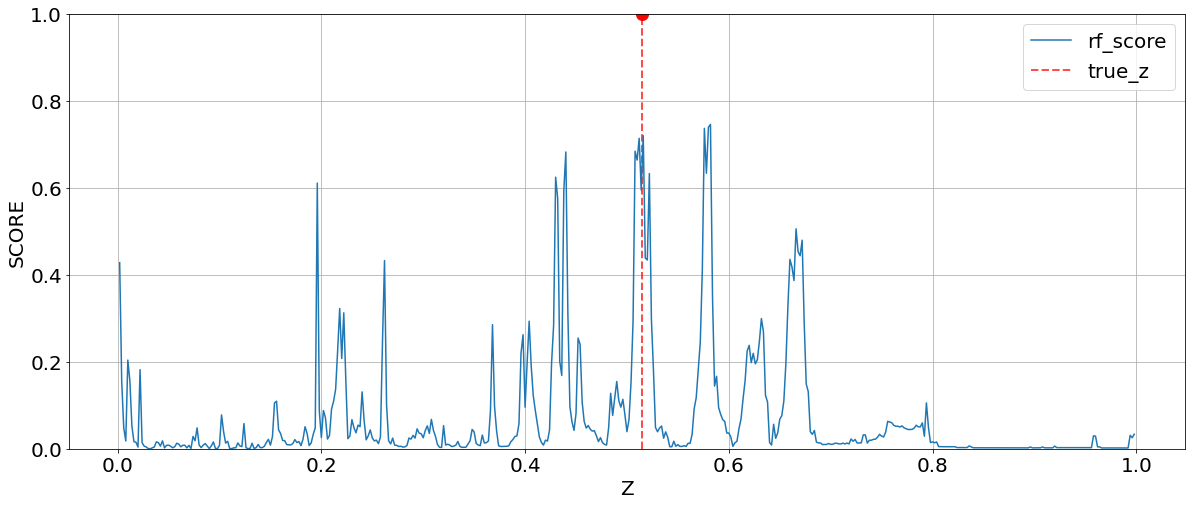

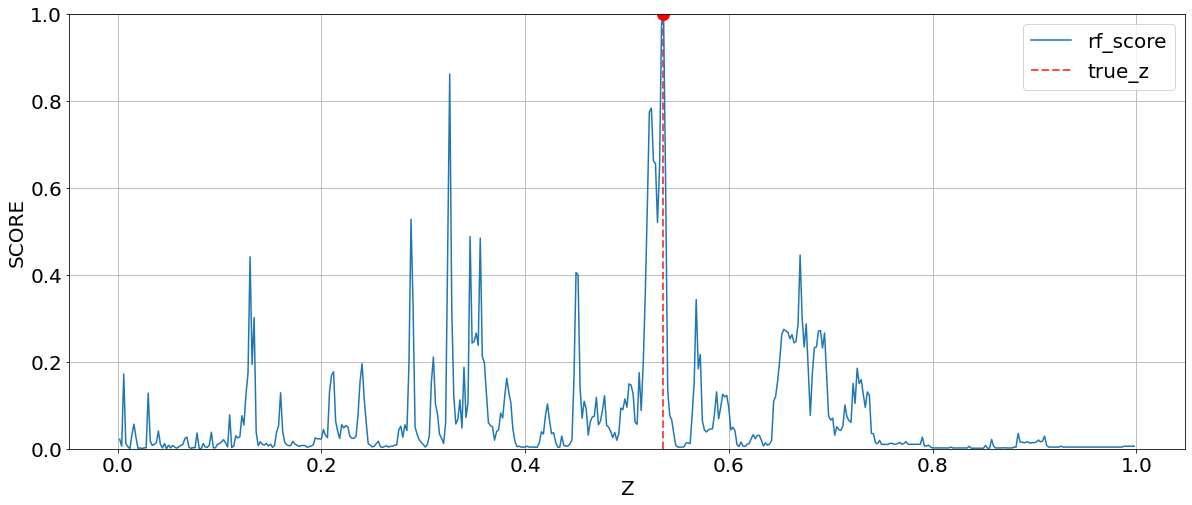

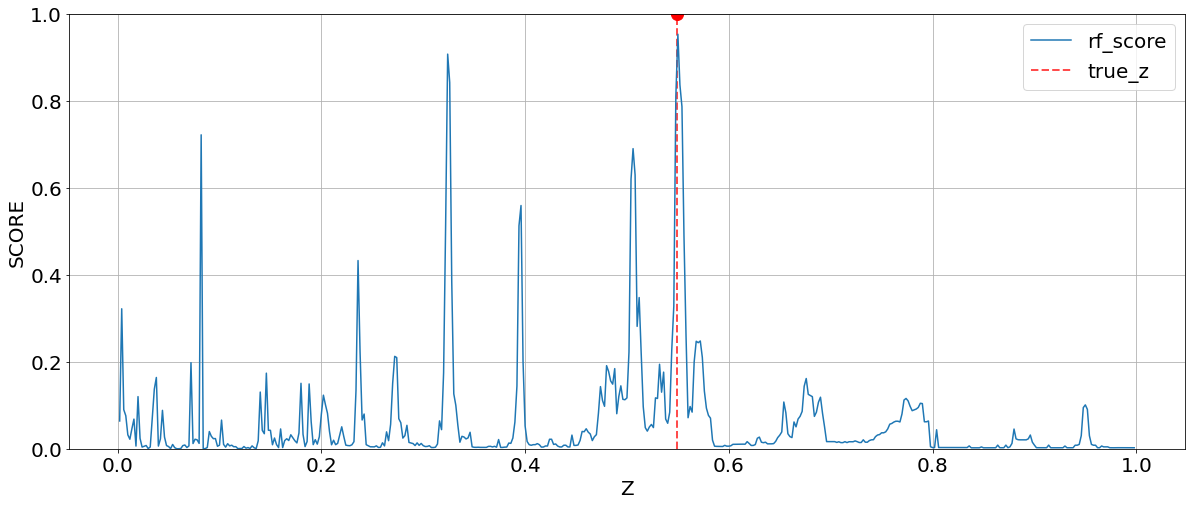

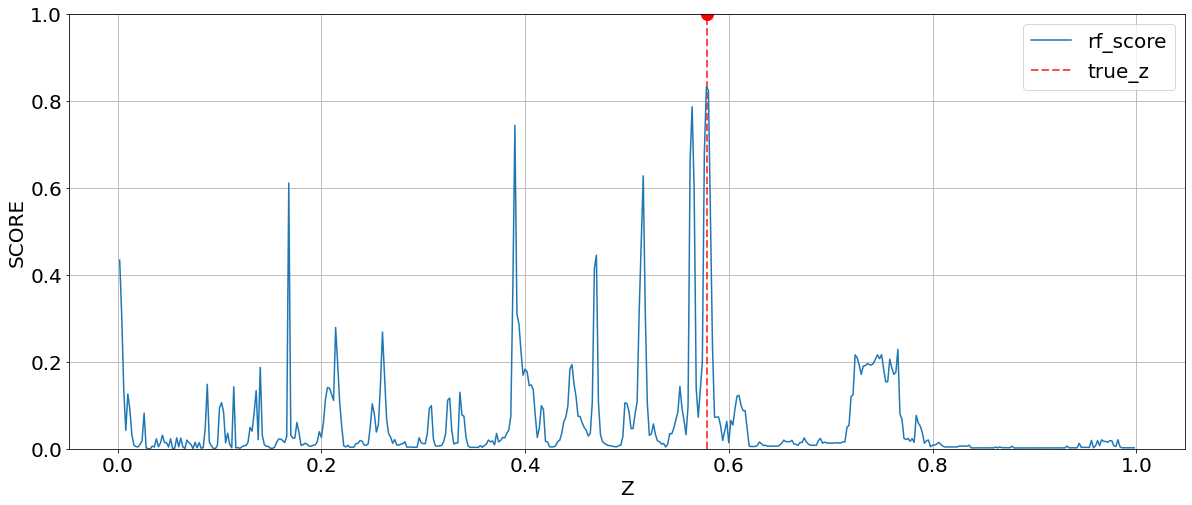

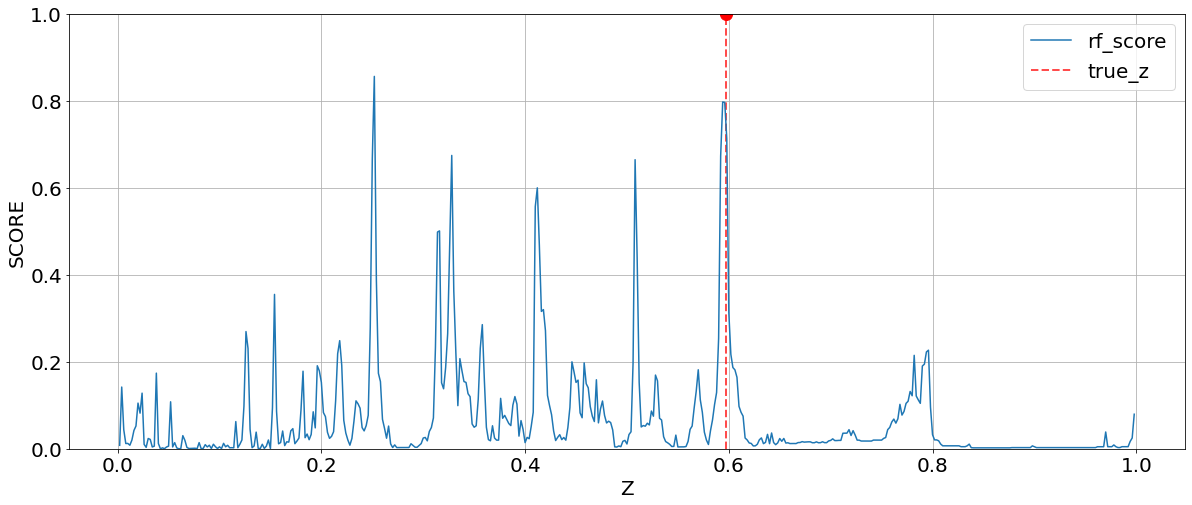

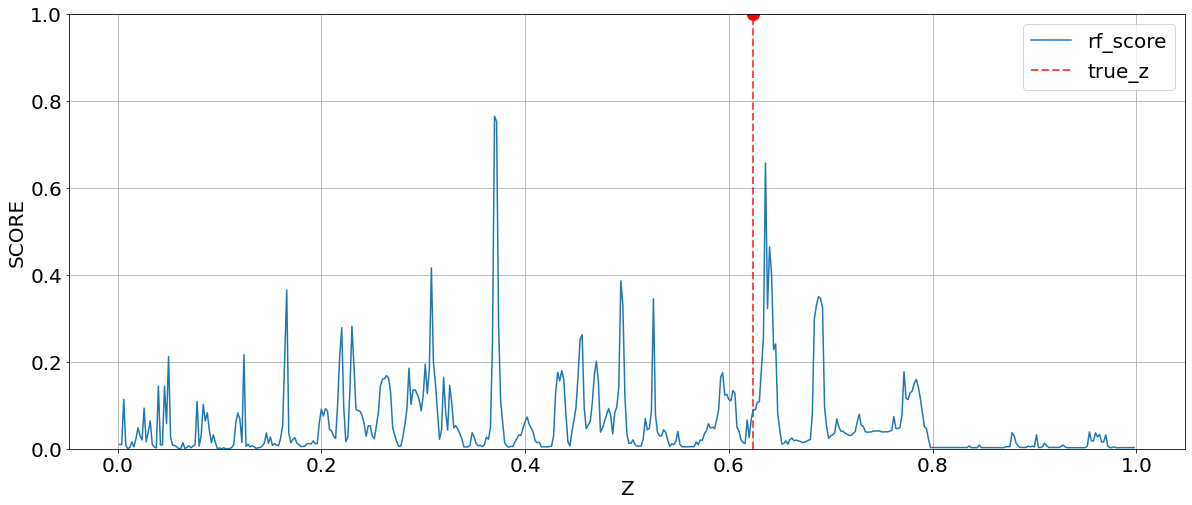

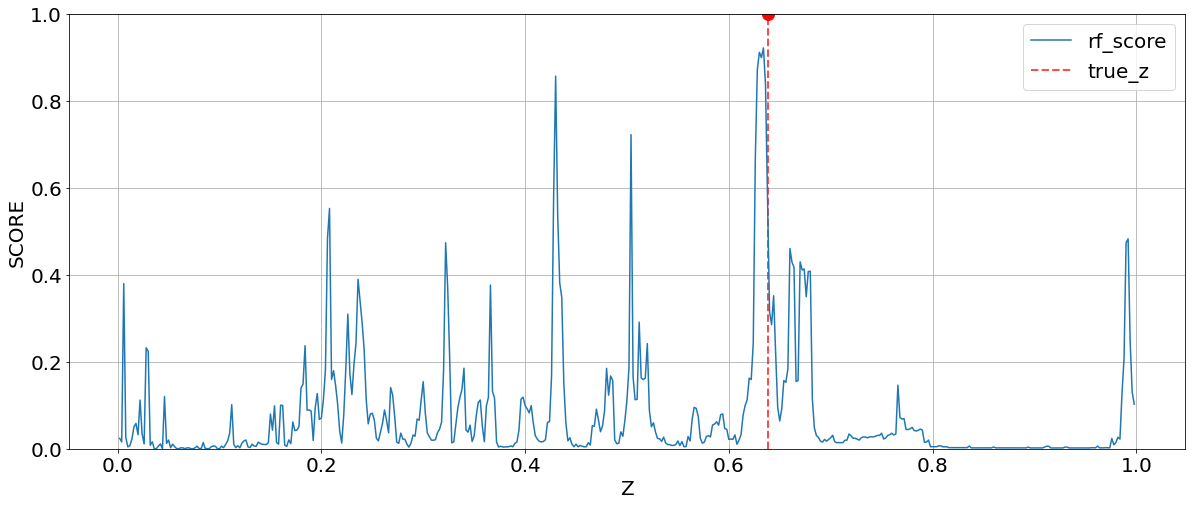

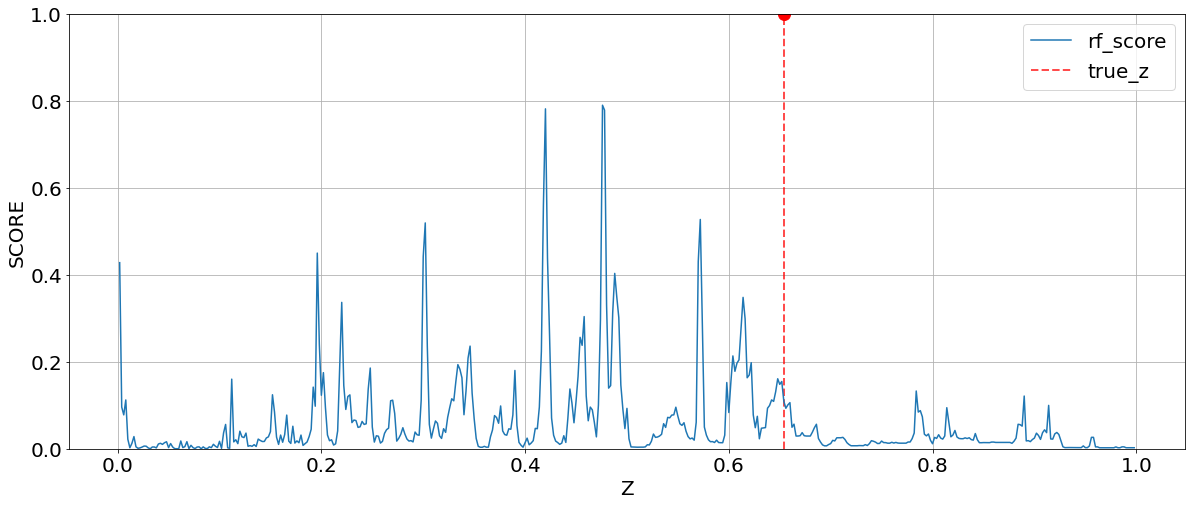

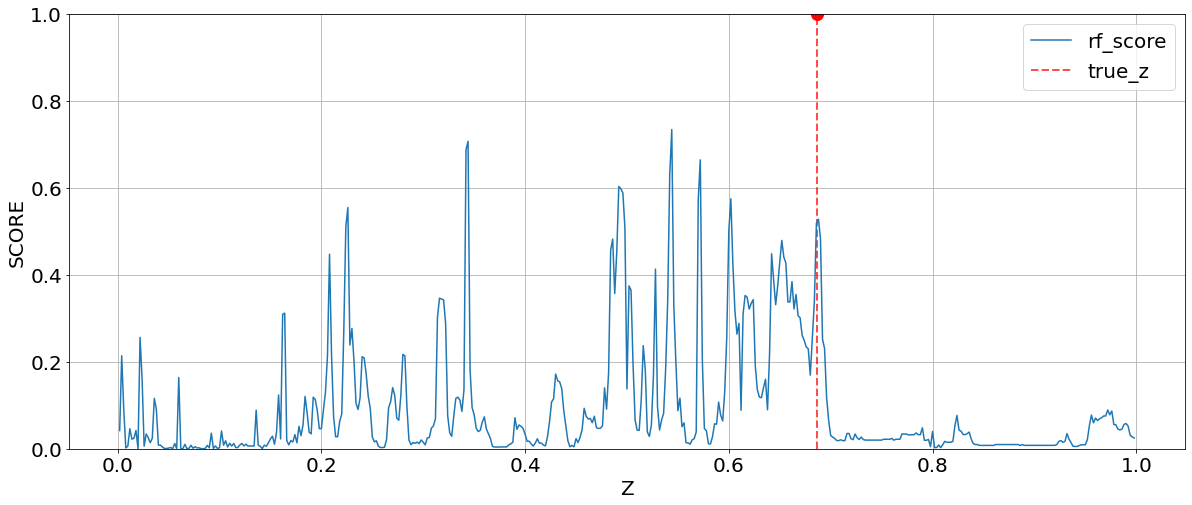

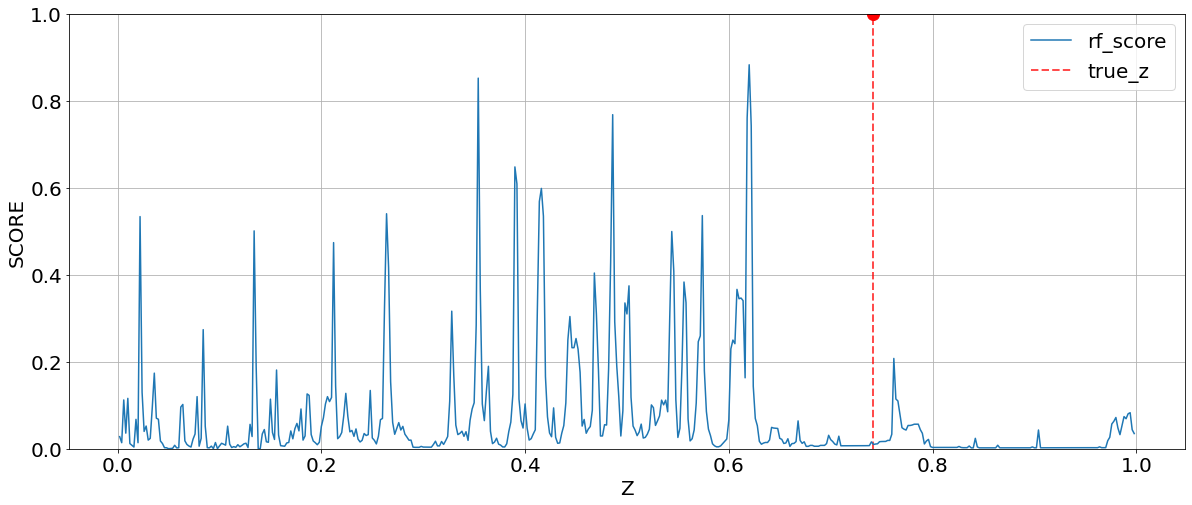

In [49]:
for i in range(test_clusters.shape[0]):
    font = {'size': 20}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(20, 8))
    plt.grid()
    plt.ylim(0, 1)

    ID = i+1

    plt.plot(
        test_clusters_ext[test_clusters_ext['ID'] == ID]['Z'][:],
        test_clusters_ext[test_clusters_ext['ID'] == ID]['rf_score'][:],
        alpha=1.0,
        label='rf_score'
    )
#     plt.plot(
#         test_clusters_ext[test_clusters_ext['ID'] == ID]['Z'][:],
#         test_clusters_ext[test_clusters_ext['ID'] == ID]['boosting_score'][:],
#         alpha=0.5,
#         label='boosting_score'
#     )
#     plt.plot(
#         test_clusters_ext[test_clusters_ext['ID'] == ID]['Z'][:],
#         test_clusters_ext[test_clusters_ext['ID'] == ID]['sigma_9_score'][:] / sigmas[-1],
#         alpha=0.5,
#         label='sigma_9_score'
#     )

    plt.plot(
        test_clusters_ext[test_clusters_ext['ID'] == ID]['Z_true'].iloc[0], 
        1, 'ro', markersize=12
    )
    plt.vlines(
        test_clusters_ext[test_clusters_ext['ID'] == ID]['Z_true'].iloc[0],
        0, 1, colors='r', linestyles='--', linewidth=2, alpha=0.7, label='true_z'
    )

    plt.xlabel('Z')
    plt.ylabel('SCORE')
    plt.legend()
    plt.savefig(f'ACT_03_cl_curves/{i}.jpg')

In [39]:
dat = Table.read('DR14Q_v4_4.fits', format='fits')
quasars = dat[['RA', 'DEC', 'Z']].to_pandas()
quasars = quasars[(cl_RA_int[0] <= quasars['RA']) & (quasars['RA'] <= cl_RA_int[1])]
quasars = quasars[(cl_DEC_int[0] <= quasars['DEC']) & (quasars['DEC'] <= cl_DEC_int[1])]
quasars = quasars[(cl_Z_int[0] < quasars['Z']) & (quasars['Z'] <= 3.0)]
quasars.drop_duplicates(subset=['RA', 'DEC', 'Z'])
quasars.reset_index(drop=True, inplace=True)
quasars = quasars.assign(R=[0] * quasars.shape[0])
quasars = quasars.assign(M=[0] * quasars.shape[0])
full_quasars = quasars.copy()
quasars.sort_values(by=['Z'], inplace=True)
quasars = quasars.iloc[list(range(0, quasars.shape[0], quasars.shape[0] // 20))]
quasars = quasars.assign(ID=list(range(1, quasars.shape[0]+1)))
quasars.reset_index(drop=True, inplace=True)
CX, CY, CZ = util_DPS.sph2cart(quasars['RA'], quasars['DEC'], quasars['Z'])
quasars['CX'] = CX
quasars['CY'] = CY
quasars['CZ'] = CZ
quasars

,RA,DEC,Z,R,M,ID,CX,CY,CZ
0,167.550323,1.224409,0.0950,0,0,1,-401.141050,88.561259,8.780135
1,219.791637,3.304770,0.5670,0,0,2,-1662.212241,-1384.492043,124.914454
2,231.577946,10.741050,0.7250,0,0,3,-1620.273922,-2042.661278,494.579965
3,229.618362,0.881991,0.8382,0,0,4,-1927.252143,-2265.984560,45.795480
4,216.249630,10.585696,1.0120,0,0,5,-2717.497004,-1992.524274,629.753335
5,190.491257,13.017807,1.2272,0,0,6,-3764.028248,-697.027299,885.021830
6,186.239288,16.542280,1.4567,0,0,7,-4193.717192,-458.493310,1253.024634
7,192.429520,9.942580,1.6251,0,0,8,-4532.624398,-999.010549,813.610946
8,173.353799,13.948486,1.8150,0,0,9,-4851.553601,565.308769,1213.148713
9,178.987671,7.771624,2.0370,0,0,10,-5321.958248,94.040676,726.445967


In [40]:
ID, RA, DEC, Z, Z_true, M, R = [], [], [], [], [], [], []
for i in range(quasars.shape[0]):
    row = quasars.iloc[i]
    ID = ID + [int(row['ID'])] * len(z)
    RA = RA + [row['RA']] * len(z)
    DEC = DEC + [row['DEC']] * len(z)
    Z = Z + z.copy()
    Z_true = Z_true + [row['Z']] * len(z)
#     TYPE = TYPE + [int(row['TYPE'])] * len(z)
    M = M + [row['M']] * len(z)
    R = R + [row['R']] * len(z)
CX, CY, CZ = util_DPS.sph2cart(RA, DEC, Z)
len(ID)

10479

In [41]:
test_quasars_ext = pd.DataFrame({
    'ID': ID, 'RA': RA, 'DEC': DEC, 'Z': Z,
    'CX': CX, 'CY': CY, 'CZ': CZ,
    'Z_true': Z_true, 'M': M, 'R': R
})
test_quasars_ext

,ID,RA,DEC,Z,CX,CY,CZ,Z_true,M,R
0,1,167.550323,1.224409,0.002,-8.633358,1.906015,0.188966,0.095,0.0,0.0
1,1,167.550323,1.224409,0.004,-17.258748,3.810272,0.377758,0.095,0.0,0.0
2,1,167.550323,1.224409,0.006,-25.876160,5.712767,0.566375,0.095,0.0,0.0
3,1,167.550323,1.224409,0.008,-34.485585,7.613499,0.754817,0.095,0.0,0.0
4,1,167.550323,1.224409,0.010,-43.087014,9.512465,0.943084,0.095,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
10474,21,238.553172,13.534887,0.990,-1710.971588,-2797.876758,789.465921,3.000,0.0,0.0
10475,21,238.553172,13.534887,0.992,-1713.513450,-2802.033355,790.638771,3.000,0.0,0.0
10476,21,238.553172,13.534887,0.994,-1716.052336,-2806.185084,791.810248,3.000,0.0,0.0
10477,21,238.553172,13.534887,0.996,-1718.588250,-2810.331953,792.980354,3.000,0.0,0.0


In [42]:
f_name = 'ACT_03_test_quasars_dists_ext.npy'
if os.path.exists(f_name):
    with open(f_name, 'rb') as f:
        test_quasars_dists_ext = np.load(f)
else:
    test_quasars_dists_ext = []
    for sigma in tqdm(sigmas):
        DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')

        _, _, cl_dists \
            = DPS.count_conn(test_quasars_ext['R'], test_quasars_ext)
        test_quasars_dists_ext.append(np.array(cl_dists)[None,:])
    test_quasars_dists_ext = np.concatenate(test_quasars_dists_ext, axis=0)
    test_quasars_dists_ext = test_quasars_dists_ext.T
    with open(f_name, 'wb') as f:
        np.save(f, test_quasars_dists_ext)
    
test_quasars_dists_ext.shape

(10479, 70)

In [43]:
test_quasars_ext_sigma_scores = []
for i, rad in tqdm(enumerate(rads)):
    s = np.zeros(test_quasars_ext.shape[0])
    for j, sigma in enumerate(sigmas):
        s[test_quasars_dists_ext[:,j] <= rad] = sigma
    test_quasars_ext_sigma_scores.append(s)
    
test_quasars_ext_sigma_scores = np.array(test_quasars_ext_sigma_scores).T
test_quasars_ext_sigma_scores.shape

30it [00:00, 818.93it/s]


(10479, 30)

In [44]:
X_test_quasars_ext = np.concatenate(
    (test_quasars_dists_ext, test_quasars_ext['Z'].values.reshape(-1, 1)),
    axis=1
)
test_quasars_ext_rf_scores = rf.predict_proba(X_test_quasars_ext)[:,1].reshape(-1)
test_quasars_ext_boosting_scores = boosting.predict_proba(X_test_quasars_ext)[:,1].reshape(-1)
test_quasars_ext_rf_scores.shape, test_quasars_ext_boosting_scores.shape

((10479,), (10479,))

In [45]:
for i, rad in enumerate(rads):
    test_quasars_ext[f'sigma_{rad}_score'] = test_quasars_ext_sigma_scores[:, i]
test_quasars_ext[f'rf_score'] =  test_quasars_ext_rf_scores
test_quasars_ext[f'boosting_score'] =  test_quasars_ext_boosting_scores

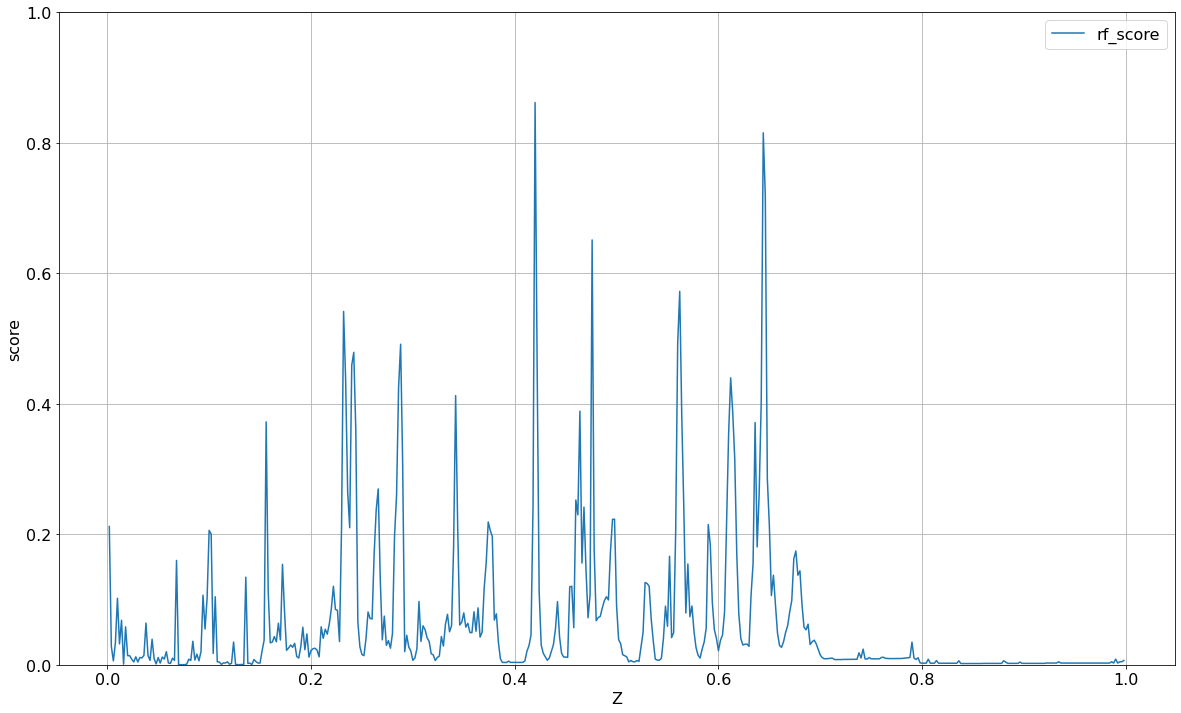

In [46]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 12))
plt.ylim(0, 1)
plt.grid()

ID = 20

plt.plot(
    test_quasars_ext[test_quasars_ext['ID'] == ID]['Z'][:],
    test_quasars_ext[test_quasars_ext['ID'] == ID]['rf_score'][:],
    alpha=1.0,
    label='rf_score'
)
# plt.plot(
#     test_quasars_ext[test_quasars_ext['ID'] == ID]['Z'][:],
#     test_quasars_ext[test_quasars_ext['ID'] == ID]['boosting_score'][:],
#     alpha=0.5,
#     label='boosting_score'
# )
# plt.plot(
#     test_quasars_ext[test_quasars_ext['ID'] == ID]['Z'][:],
#     test_quasars_ext[test_quasars_ext['ID'] == ID]['sigma_9_score'][:] / sigmas[-1],
#     alpha=0.5,
#     label='sigma_9_score'
# )

# plt.plot(
#     test_quasars_ext[test_quasars_ext['ID'] == ID]['Z_true'].iloc[0], 
#     1, 'ro', markersize=12
# )
# plt.vlines(
#     test_quasars_ext[test_quasars_ext['ID'] == ID]['Z_true'].iloc[0],
#     0, 1, colors='r', linestyles='--', linewidth=1, alpha=0.3
# )

plt.xlabel('Z')
plt.ylabel('score')
plt.legend()